# Capstone Project: Random Forest Regression: SGCarMart Used Cars Price Predictor

In [74]:
import pandas as pd
import numpy as np
from datetime import date

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import matplotlib.pyplot as plt
import seaborn as sns

### Pre-defined Functions

In [75]:
def plot_corr_matrix_heatmap(df):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(df.corr(), dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure to control size of heatmap
    fig, ax = plt.subplots(figsize=(15, 15))

    # Create a custom color palette
    cmap = sns.diverging_palette(220, 20, as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
    # Blue = Good (low correlation), Red = Bad (high correlation) between the independent variables

    # Plot the heatmap
    sns.heatmap(df.corr(), mask=mask, annot=True, square=True, cmap=cmap, vmin=-1, vmax=1, ax=ax)

    # Prevent Heatmap Cut-Off Issue
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    plt.show()

In [76]:
def linear_regression_analysis(X, Y):
    """
    Perform linear regression analysis and return the summary of the results.

    Parameters:
    X (DataFrame): Independent variables (features)
    Y (Series): Dependent variable (target)

    Returns:
    summary: Summary of the regression results
    """
    # Add a constant to the independent variables
    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(Y, X)
    results = model.fit()

    # Return the summary of the results
    return results.summary()

In [77]:
def random_forest_analysis(X, Y, n_estimators=100, random_state=42):
    """
    Perform Random Forest regression analysis and return the model's performance metrics.

    Parameters:
    X (DataFrame): Independent variables (features)
    Y (Series): Dependent variable (target)
    n_estimators (int): Number of trees in the forest (default is 100)
    random_state (int): Random seed for reproducibility (default is 42)

    Returns:
    dict: Dictionary containing RMSE and R^2 score
    """
    # Initialize the Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)

    # Fit the model
    rf.fit(X, Y)

    # Predict the target variable
    Y_pred = rf.predict(X)

    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(Y, Y_pred))
    r2 = r2_score(Y, Y_pred)

    return {'RMSE': rmse, 'R^2': r2}

### Section 1: DataFrame Loading, Cleaning

In [78]:
# Use the dir() function to view all variables in the current environment.
# Refer to this link for more information: https://stackoverflow.com/questions/633127/viewing-all-defined-variables
# This link provides a solution to view all defined variables in the current environment.

In [79]:
df_main = pd.read_csv('sgcarmart_used_cars_prices.csv',index_col=0)

df_main.columns
len(df_main.columns)

19

In [80]:
df_main.sample(10)

,LISTING_URL,BRAND,PRICE,DEPRE_YEARLY,REG_DATE,MILEAGE_KM,MANUFACTURED_YEAR,ROAD_TAX_YEARLY,TRANSMISSION,DEREG_VALUE_FROM_SCRAPE_DATE,SCRAPE_DATE,OMV,ARF,COE_FROM_SCRAPE_DATE,DAYS_OF_COE_LEFT,ENGINE_CAPACITY_CC,CURB_WEIGHT_KG,NO_OF_OWNERS,VEHICLE_TYPE
125,https://www.sgcarmart.com/used_cars/info.php?I...,Peugeot 3008 1.6A EAT6 Allure,69800,13700.0,02-Aug-2018,118863.0,2018,742,Auto,34060.0,09/09/2024,29207.0,32890.0,32551.0,1188,1598.0,1300.0,1,SUV
44,https://www.sgcarmart.com/used_cars/info.php?I...,Mercedes-Benz AMG GT 63 S 4MATIC+,400788,48620.0,20-Sep-2019,47000.0,2019,3922,Auto,254444.0,09/09/2024,189128.0,312431.0,40001.0,1830,3982.0,2120.0,1,Sports Car
64,https://www.sgcarmart.com/used_cars/info.php?I...,BMW 1 Series 116d,34800,14390.0,30-Sep-2016,109000.0,Hatchback,1082,2016,17983.0,09/09/2024,NaN,NaN,56956.0,732,1496.0,1350.0,1,NaN
47,https://www.sgcarmart.com/used_cars/info.php?I...,Honda N-Box L,142800,15110.0,21-Dec-2023,39.0,2022,326,Auto,74166.0,09/09/2024,15456.0,5000.0,88020.0,3564,658.0,900.0,1,Hatchback
113,https://www.sgcarmart.com/used_cars/info.php?I...,Honda Shuttle 1.5A G,86800,12860.0,30-Mar-2021,22800.0,2021,682,Auto,30620.0,09/09/2024,19644.0,5000.0,41001.0,2376,1496.0,1130.0,1,Stationwagon
83,https://www.sgcarmart.com/used_cars/info.php?I...,Lexus GS450h Hybrid,55800,9330.0,29-Sep-2010,153888.0,Luxury,4340,2010,19676.0,09/09/2024,NaN,NaN,32914.0,1980,3456.0,1860.0,1,NaN
37,https://www.sgcarmart.com/used_cars/info.php?I...,Mazda 3 1.5A Standard Plus Sunroof,55800,11150.0,29-Aug-2014,NaN,2014,682,Auto,NaN,09/09/2024,18631.0,8631.0,NaN,1825,1496.0,1339.0,1,Mid-Sized Sedan
5,https://www.sgcarmart.com/used_cars/info.php?I...,Peugeot 508 Diesel 1.6A BlueHDi Allure,23888,10910.0,25-Feb-2016,110000.0,Luxury,1144,2015,15186.0,09/09/2024,NaN,NaN,44001.0,396,1560.0,1445.0,1,NaN
33,https://www.sgcarmart.com/used_cars/info.php?I...,Kia Stonic 1.0T,71800,13610.0,03-Sep-2019,62871.0,2019,392,Auto,19814.0,09/09/2024,17952.0,7952.0,28589.0,1584,998.0,1185.0,1,SUV
152,https://www.sgcarmart.com/used_cars/info.php?I...,Hyundai Avante 1.6M,38800,8360.0,10-Jun-2009,178000.0,2009,1107,Manual,12148.0,09/09/2024,9306.0,9306.0,26175.0,1584,1591.0,1264.0,1,Mid-Sized Sedan


In [81]:
df_clean = df_main.drop(['LISTING_URL', 'SCRAPE_DATE'],axis=1) #Drop columns that were used for reference purposes.
# There are NA entries in the dataset.
# Dropping these NA values is necessary to avoid future problems.
# Null values may occur due to missing data or formatting issues in the car listings.
# Varying ways of organizing information in a single listing can contribute to these formatting issues.

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 0 to 199
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   BRAND                         200 non-null    object 
 1   PRICE                         200 non-null    int64  
 2   DEPRE_YEARLY                  197 non-null    float64
 3   REG_DATE                      200 non-null    object 
 4   MILEAGE_KM                    179 non-null    float64
 5   MANUFACTURED_YEAR             200 non-null    object 
 6   ROAD_TAX_YEARLY               200 non-null    int64  
 7   TRANSMISSION                  200 non-null    object 
 8   DEREG_VALUE_FROM_SCRAPE_DATE  188 non-null    float64
 9   OMV                           161 non-null    float64
 10  ARF                           161 non-null    float64
 11  COE_FROM_SCRAPE_DATE          187 non-null    float64
 12  DAYS_OF_COE_LEFT              200 non-null    int64  
 13  ENGINE_CAP

In [82]:
# After dropping null values, we have rows of data remaining
df_clean.dropna(inplace=True)

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129 entries, 0 to 199
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   BRAND                         129 non-null    object 
 1   PRICE                         129 non-null    int64  
 2   DEPRE_YEARLY                  129 non-null    float64
 3   REG_DATE                      129 non-null    object 
 4   MILEAGE_KM                    129 non-null    float64
 5   MANUFACTURED_YEAR             129 non-null    object 
 6   ROAD_TAX_YEARLY               129 non-null    int64  
 7   TRANSMISSION                  129 non-null    object 
 8   DEREG_VALUE_FROM_SCRAPE_DATE  129 non-null    float64
 9   OMV                           129 non-null    float64
 10  ARF                           129 non-null    float64
 11  COE_FROM_SCRAPE_DATE          129 non-null    float64
 12  DAYS_OF_COE_LEFT              129 non-null    int64  
 13  ENGINE_CAP

In [83]:
df_clean.sample(10)

,BRAND,PRICE,DEPRE_YEARLY,REG_DATE,MILEAGE_KM,MANUFACTURED_YEAR,ROAD_TAX_YEARLY,TRANSMISSION,DEREG_VALUE_FROM_SCRAPE_DATE,OMV,ARF,COE_FROM_SCRAPE_DATE,DAYS_OF_COE_LEFT,ENGINE_CAPACITY_CC,CURB_WEIGHT_KG,NO_OF_OWNERS,VEHICLE_TYPE
47,Honda N-Box L,142800,15110.0,21-Dec-2023,39.0,2022,326,Auto,74166.0,15456.0,5000.0,88020.0,3564,658.0,900.0,1,Hatchback
158,Jaguar F-PACE 3.0A V6 Supercharged S R-Sport,129800,26400.0,15-Jun-2017,96000.0,2017,2380,Auto,83450.0,78758.0,113765.0,55000.0,792,2995.0,1856.0,1,SUV
59,Audi S5 Cabriolet 3.0A TFSI Quattro,90800,17840.0,12-Oct-2009,123000.0,2009,3570,Auto,19090.0,75876.0,75876.0,37502.0,1980,2995.0,1875.0,1,Sports Car
77,Mercedes-Benz C-Class C180 Cabriolet AMG Line,219800,27550.0,19-May-2021,1473.0,2020,684,Auto,85023.0,54992.0,70986.0,47506.0,2376,1497.0,1710.0,1,Sports Car
165,Mercedes-Benz E-Class E250 Cabriolet CGI Avant...,83450,14320.0,08-Jul-2010,120000.0,2010,1461,Auto,19561.0,56896.0,56896.0,33568.0,1980,1796.0,1695.0,1,Sports Car
125,Peugeot 3008 1.6A EAT6 Allure,69800,13700.0,02-Aug-2018,118863.0,2018,742,Auto,34060.0,29207.0,32890.0,32551.0,1188,1598.0,1300.0,1,SUV
22,Toyota Harrier 2.0A Premium Panoramic Roof,75800,20420.0,07-Aug-2017,115000.0,2016,1196,Auto,34241.0,32781.0,32894.0,49899.0,792,1986.0,1610.0,1,SUV
96,Hyundai Elantra 1.6A GLS S,48800,14820.0,20-Jul-2017,79000.0,2017,738,Auto,19959.0,12881.0,12881.0,42801.0,792,1591.0,1345.0,1,Mid-Sized Sedan
137,Nissan Note 1.2A,53800,11480.0,27-Feb-2019,85000.0,2019,508,Auto,15253.0,13467.0,5000.0,26301.0,1584,1198.0,1048.0,1,Hatchback
164,Porsche Cayenne 3.0A Tip,283800,45390.0,22-Jul-2019,49000.0,2019,2380,Auto,109086.0,85487.0,125877.0,43102.0,1584,2995.0,1985.0,1,SUV


In [84]:
# 17 variables in columns after cleaning
print(df_clean.columns,'\n',len(df_clean.columns))

Index(['BRAND', 'PRICE', 'DEPRE_YEARLY', 'REG_DATE', 'MILEAGE_KM',
       'MANUFACTURED_YEAR', 'ROAD_TAX_YEARLY', 'TRANSMISSION',
       'DEREG_VALUE_FROM_SCRAPE_DATE', 'OMV', 'ARF', 'COE_FROM_SCRAPE_DATE',
       'DAYS_OF_COE_LEFT', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'VEHICLE_TYPE'],
      dtype='object') 
 17


## Section 2: Data Categorizing

### Section 2.1: One-hot encoding TRANSMISSION Column

In [85]:
#The transmission options in this dataset are limited to Auto or Manual.
#To handle this, apply one-hot encoding to represent the transmission variable.
df_clean['TRANSMISSION'].value_counts()

TRANSMISSION
Auto      127
Manual      2
Name: count, dtype: int64

In [86]:
# Transmission conversion -> 1 for auto, 0 for manual (just 1 column only)
df_clean['TRANSMISSION_CONVERT'] = df_clean['TRANSMISSION'].apply(lambda x: 1 if x == 'Auto' else 0)
df_clean.drop('TRANSMISSION',axis=1,inplace=True)
df_clean.rename(columns={'TRANSMISSION_CONVERT':"TRANSMISSION"}, inplace=True)  # Renaming column back

In [87]:
df_clean.sample(10)

,BRAND,PRICE,DEPRE_YEARLY,REG_DATE,MILEAGE_KM,MANUFACTURED_YEAR,ROAD_TAX_YEARLY,DEREG_VALUE_FROM_SCRAPE_DATE,OMV,ARF,COE_FROM_SCRAPE_DATE,DAYS_OF_COE_LEFT,ENGINE_CAPACITY_CC,CURB_WEIGHT_KG,NO_OF_OWNERS,VEHICLE_TYPE,TRANSMISSION
150,MINI Cooper S Clubman 1.6A,81800,19230.0,11-Dec-2008,120000.0,2008,1113,11731.0,35440.0,35440.0,27571.0,1584,1598.0,1230.0,1,Sports Car,1
32,Volvo XC60 T5 Momentum,93800,21810.0,15-Dec-2017,79000.0,2017,1176,48178.0,38070.0,45298.0,57414.0,1188,1969.0,1841.0,1,SUV,1
183,Mercedes-Benz C-Class C180,123000,14230.0,11-Jun-2013,128000.0,2013,888,69342.0,31746.0,31445.0,86677.0,3168,1595.0,1485.0,1,Luxury Sedan,1
90,Kia Cerato 1.6A SX Sunroof,61800,12910.0,12-Oct-2018,64000.0,2018,738,24038.0,17979.0,17979.0,28000.0,1584,1591.0,1287.0,1,Mid-Sized Sedan,1
181,Mercedes-Benz GLB-Class GLB200 AMG Line Sunroof,188800,25910.0,25-Jan-2021,64000.0,2020,586,66737.0,39327.0,47058.0,49300.0,2376,1332.0,1555.0,1,SUV,1
17,SEAT Leon CUPRA Formentor 2.0A TSI DSG,170000,19460.0,06-Jul-2022,25000.0,2021,1194,109513.0,31020.0,35428.0,106001.0,2772,1984.0,1596.0,1,SUV,1
199,Chevrolet Cruze 1.6A,17388,9000.0,16-Aug-2011,148000.0,2011,965,8954.0,11692.0,11692.0,23179.0,396,1598.0,1310.0,1,Mid-Sized Sedan,1
53,Toyota Raize 1.0A G,121800,14670.0,14-Oct-2022,38000.0,2020,392,62934.0,20750.0,6050.0,72996.0,3168,996.0,970.0,1,SUV,1
8,Subaru Forester 2.0i-L Sunroof,51800,13360.0,29-Jan-2018,118083.0,2017,1208,21410.0,13108.0,13108.0,38064.0,1188,1995.0,1591.0,1,SUV,1
163,Infiniti Q60 Coupe 2.0A T,78888,20030.0,30-Jun-2017,99000.0,2017,1202,42721.0,38231.0,45524.0,55000.0,792,1991.0,1692.0,1,Sports Car,1


In [88]:
# Performing whitespace stripping prior to dtype manipulation
df_clean['VEHICLE_TYPE'].apply(str.strip)
df_clean['VEHICLE_TYPE'].apply(str.lstrip)

# Inspection of the type of Vehicles
df_clean['VEHICLE_TYPE'].value_counts()

VEHICLE_TYPE
SUV                39
Mid-Sized Sedan    28
Luxury Sedan       22
Sports Car         19
Hatchback          14
MPV                 4
Stationwagon        3
Name: count, dtype: int64

### Section 2.2: Datetime conversion

In [89]:
#df_clean['REG_DATE'] = pd.to_datetime(df_clean['REG_DATE'], format='%d-%b-%y')
#df_clean['MANUFACTURED_YEAR'] = df_clean['MANUFACTURED_YEAR'].astype(int)
#df_clean[['REG_DATE','MANUFACTURED_YEAR']].dtypes

print(df_clean[['REG_DATE', 'MANUFACTURED_YEAR']].dtypes)

df_clean['REG_DATE'] = pd.to_datetime(df_clean['REG_DATE'], format='%d-%b-%Y', errors='coerce')
df_clean['MANUFACTURED_YEAR'] = df_clean['MANUFACTURED_YEAR'].astype(int)

# Display the data types
print(df_clean[['REG_DATE', 'MANUFACTURED_YEAR']].dtypes)

# Check for any entries that couldn't be converted
invalid_dates = df_clean[df_clean['REG_DATE'].isna()]
print("Invalid dates found:\n", invalid_dates)

REG_DATE             object
MANUFACTURED_YEAR    object
dtype: object
REG_DATE             datetime64[ns]
MANUFACTURED_YEAR             int32
dtype: object
Invalid dates found:
 Empty DataFrame
Columns: [BRAND, PRICE, DEPRE_YEARLY, REG_DATE, MILEAGE_KM, MANUFACTURED_YEAR, ROAD_TAX_YEARLY, DEREG_VALUE_FROM_SCRAPE_DATE, OMV, ARF, COE_FROM_SCRAPE_DATE, DAYS_OF_COE_LEFT, ENGINE_CAPACITY_CC, CURB_WEIGHT_KG, NO_OF_OWNERS, VEHICLE_TYPE, TRANSMISSION]
Index: []


In [90]:
# Converting reg_date to datetime follwed by int in YYYYMMDD, and Manufactured year to int

# Converting REG_DATE to datetime and MANUFACTURED_YEAR to int
#df_clean['REG_DATE'] = pd.to_datetime(df_clean['REG_DATE'], format='%d-%b-%y', errors='coerce')
#df_clean['MANUFACTURED_YEAR'] = df_clean['MANUFACTURED_YEAR'].astype(int)

# Extracting year, month, and day
#df_clean['YEAR'] = df_clean['REG_DATE'].dt.year
#df_clean['MONTH'] = df_clean['REG_DATE'].dt.month
#df_clean['DAY'] = df_clean['REG_DATE'].dt.day

# Creating YYYYMMDD format
#df_clean['REG_DATE_CONVERT'] = df_clean['YEAR']*10000 + df_clean['MONTH']*100 + df_clean['DAY']

# Dropping the original REG_DATE column and renaming the new column
#df_clean.drop('REG_DATE', axis=1, inplace=True)
#df_clean.rename(columns={'REG_DATE_CONVERT': 'REG_DATE'}, inplace=True)

# Dropping temporary columns
#df_clean = df_clean.drop(columns=['YEAR', 'MONTH', 'DAY'])

# Displaying the data types
#print(df_clean[['REG_DATE', 'MANUFACTURED_YEAR']].dtypes)
#print(df_clean)


In [91]:
df_clean.dtypes

BRAND                                   object
PRICE                                    int64
DEPRE_YEARLY                           float64
REG_DATE                        datetime64[ns]
MILEAGE_KM                             float64
MANUFACTURED_YEAR                        int32
ROAD_TAX_YEARLY                          int64
DEREG_VALUE_FROM_SCRAPE_DATE           float64
OMV                                    float64
ARF                                    float64
COE_FROM_SCRAPE_DATE                   float64
DAYS_OF_COE_LEFT                         int64
ENGINE_CAPACITY_CC                     float64
CURB_WEIGHT_KG                         float64
NO_OF_OWNERS                             int64
VEHICLE_TYPE                            object
TRANSMISSION                             int64
dtype: object

In [92]:
if df_main['SCRAPE_DATE'].dtype == object:
    df_main['SCRAPE_DATE'] = \
    pd.to_datetime(df_main['SCRAPE_DATE']).dt.year # Convert the scrape date column to an integer format to enable operations on the dates.
    df_main['SCRAPE_DATE'] # Checking dtype

In [93]:
# Convert the current scrape date from the main dataframe to a datetime object.

# Calculate the number of years from the year of manufacture to the current year to determine how new the car is.
df_clean['CAR_AGE'] = df_main['SCRAPE_DATE'] - df_clean['MANUFACTURED_YEAR'] # Obtain the values for the age of the car.
df_clean['CAR_AGE'].astype(int)

0       4
1       6
3       3
4       5
6       8
       ..
192     4
193     3
194     4
195     8
199    13
Name: CAR_AGE, Length: 129, dtype: int32

In [94]:
# Rearrange Columns 
df_clean = df_clean[['BRAND', 'PRICE', 'DEPRE_YEARLY', 'MILEAGE_KM', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT', 
                    'REG_DATE', 'MANUFACTURED_YEAR', 'CAR_AGE', 'DEREG_VALUE_FROM_SCRAPE_DATE', 'OMV', 'ARF', 
                    'ENGINE_CAPACITY_CC', 'ROAD_TAX_YEARLY', 'CURB_WEIGHT_KG',
                    'NO_OF_OWNERS', 'VEHICLE_TYPE', 'TRANSMISSION']]
df_clean.head()

,BRAND,PRICE,DEPRE_YEARLY,MILEAGE_KM,COE_FROM_SCRAPE_DATE,DAYS_OF_COE_LEFT,REG_DATE,MANUFACTURED_YEAR,CAR_AGE,DEREG_VALUE_FROM_SCRAPE_DATE,OMV,ARF,ENGINE_CAPACITY_CC,ROAD_TAX_YEARLY,CURB_WEIGHT_KG,NO_OF_OWNERS,VEHICLE_TYPE,TRANSMISSION
0,Mercedes-Benz A-Class A180,163800,16880.0,5600.0,121000.0,3168,2023-08-17,2020,4.0,116163.0,24155.0,25817.0,1332.0,586,1365.0,1,Hatchback,1
1,BMW X2 sDrive18i M-Sport,105800,18410.0,68500.0,39401.0,1584,2019-03-28,2018,6.0,48823.0,37248.0,44148.0,1499.0,684,1415.0,1,SUV,1
3,Toyota GR Yaris 1.6M Circuit Pack,174888,22340.0,31000.0,61190.0,2376,2021-06-17,2021,3.0,76912.0,39511.0,47316.0,1618.0,766,1280.0,1,Sports Car,0
4,BMW X3 sDrive20i,129800,22400.0,85900.0,52502.0,1584,2019-05-29,2019,5.0,58533.0,40167.0,48234.0,1998.0,1210,1660.0,1,SUV,1
6,BMW 3 Series 318i,51988,16940.0,105000.0,56206.0,792,2016-11-29,2016,8.0,29756.0,29860.0,28804.0,1499.0,684,1425.0,1,Luxury Sedan,1


## Section 2.3: VEHICLE_TYPE To Dummy Variables

In [95]:
# Making Dummy Variables out of Vehicle Types:

x_vehtype_dummy = patsy.dmatrix('VEHICLE_TYPE',data=df_clean,return_type='dataframe')
x_vehtype_dummy.head()


,Intercept,VEHICLE_TYPE[T.Luxury Sedan],VEHICLE_TYPE[T.MPV],VEHICLE_TYPE[T.Mid-Sized Sedan],VEHICLE_TYPE[T.SUV],VEHICLE_TYPE[T.Sports Car],VEHICLE_TYPE[T.Stationwagon]
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [96]:
df_clean2 = df_clean.join(x_vehtype_dummy)
df_clean2

,BRAND,PRICE,DEPRE_YEARLY,MILEAGE_KM,COE_FROM_SCRAPE_DATE,DAYS_OF_COE_LEFT,REG_DATE,MANUFACTURED_YEAR,CAR_AGE,DEREG_VALUE_FROM_SCRAPE_DATE,...,NO_OF_OWNERS,VEHICLE_TYPE,TRANSMISSION,Intercept,VEHICLE_TYPE[T.Luxury Sedan],VEHICLE_TYPE[T.MPV],VEHICLE_TYPE[T.Mid-Sized Sedan],VEHICLE_TYPE[T.SUV],VEHICLE_TYPE[T.Sports Car],VEHICLE_TYPE[T.Stationwagon]
0,Mercedes-Benz A-Class A180,163800,16880.0,5600.0,121000.0,3168,2023-08-17,2020,4.0,116163.0,...,1,Hatchback,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BMW X2 sDrive18i M-Sport,105800,18410.0,68500.0,39401.0,1584,2019-03-28,2018,6.0,48823.0,...,1,SUV,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Toyota GR Yaris 1.6M Circuit Pack,174888,22340.0,31000.0,61190.0,2376,2021-06-17,2021,3.0,76912.0,...,1,Sports Car,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,BMW X3 sDrive20i,129800,22400.0,85900.0,52502.0,1584,2019-05-29,2019,5.0,58533.0,...,1,SUV,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6,BMW 3 Series 318i,51988,16940.0,105000.0,56206.0,792,2016-11-29,2016,8.0,29756.0,...,1,Luxury Sedan,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Toyota Raize 1.0A G,97800,14980.0,50000.0,40556.0,2376,2021-01-02,2020,4.0,30452.0,...,1,SUV,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0
193,BMW 2 Series 218i Gran Coupe Luxury,143800,17440.0,47000.0,64700.0,2562,2021-09-29,2021,3.0,75321.0,...,1,Luxury Sedan,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0
194,Porsche Macan 2.0A PDK,345800,34110.0,20000.0,118501.0,3168,2023-06-06,2020,4.0,154801.0,...,1,SUV,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0
195,Hyundai Tucson 2.0A GLS,33600,15350.0,91500.0,47000.0,396,2016-04-12,2016,8.0,17630.0,...,1,SUV,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## Section 2.4: Car Brand Categorization. Includes:
* Splitting them into Dummy Variables
* Indexing them into price range categories (perhaps better metric over vehicle types)
* Converting lesser-known brands into "others"

In [97]:
# Renaming Brand Names to their actual names

df_clean2.loc[df_clean2['BRAND'] == 'Aston','BRAND'] = 'Aston Martin'
df_clean2.loc[df_clean2['BRAND'] == 'Land','BRAND'] = 'Land Rover'
df_clean2.loc[df_clean2['BRAND'] == 'Alfa', 'BRAND'] = 'Alfa Romeo'

In [98]:
# Cleaning whitespaces from the values in "Brand" to prevent any messup later
df_clean2['BRAND'].apply(str.strip)

# Checking the number of brands in the dataset
print("# Of rows in DataFrame in Brands Column:\n", df_clean2.loc[:,'BRAND'])
print("\nValue Counts of Brands:\n", df_clean2.loc[:,'BRAND'].value_counts())
print("\n# of Brands:", len(df_clean2.loc[:,'BRAND'].value_counts()))

# New Column ATAS
# New Column Budget Cars
# Top 20 brands
# Am I comfortable with grouping uncommon cars into others?

# Of rows in DataFrame in Brands Column:
 0               Mercedes-Benz A-Class A180
1                 BMW X2 sDrive18i M-Sport
3        Toyota GR Yaris 1.6M Circuit Pack
4                         BMW X3 sDrive20i
6                        BMW 3 Series 318i
                      ...                 
192                    Toyota Raize 1.0A G
193    BMW 2 Series 218i Gran Coupe Luxury
194                 Porsche Macan 2.0A PDK
195                Hyundai Tucson 2.0A GLS
199                   Chevrolet Cruze 1.6A
Name: BRAND, Length: 129, dtype: object

Value Counts of Brands:
 BRAND
Hyundai Elantra 1.6A GLS S                 4
Mercedes-Benz C-Class C180 Avantgarde      3
Mercedes-Benz CLA-Class CLA180 AMG Line    2
Toyota Raize 1.0A G                        2
Honda Shuttle 1.5A G                       2
                                          ..
Audi S5 Cabriolet 3.0A TFSI Quattro        1
Kia Cerato Forte 1.6A EX                   1
Honda N-Box L                              1
Porsche 

## Section 3: Data Visualization
* EDA  
* Correlation Matrix  
* Pairplots  

### Section 3.1: Preliminary Correlation Exploration
### Section 3.1.1: Analysis without Car Brands and Vehicle Types for Feature Dropping

In [99]:
df_clean2.columns

Index(['BRAND', 'PRICE', 'DEPRE_YEARLY', 'MILEAGE_KM', 'COE_FROM_SCRAPE_DATE',
       'DAYS_OF_COE_LEFT', 'REG_DATE', 'MANUFACTURED_YEAR', 'CAR_AGE',
       'DEREG_VALUE_FROM_SCRAPE_DATE', 'OMV', 'ARF', 'ENGINE_CAPACITY_CC',
       'ROAD_TAX_YEARLY', 'CURB_WEIGHT_KG', 'NO_OF_OWNERS', 'VEHICLE_TYPE',
       'TRANSMISSION', 'Intercept', 'VEHICLE_TYPE[T.Luxury Sedan]',
       'VEHICLE_TYPE[T.MPV]', 'VEHICLE_TYPE[T.Mid-Sized Sedan]',
       'VEHICLE_TYPE[T.SUV]', 'VEHICLE_TYPE[T.Sports Car]',
       'VEHICLE_TYPE[T.Stationwagon]'],
      dtype='object')

In [100]:
df_price_no_brands = df_clean2[['PRICE', 'DEPRE_YEARLY', 'MILEAGE_KM',
       'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT', 'REG_DATE',
       'MANUFACTURED_YEAR', 'CAR_AGE', 'DEREG_VALUE_FROM_SCRAPE_DATE', 'OMV',
       'ARF', 'ENGINE_CAPACITY_CC', 'ROAD_TAX_YEARLY', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'VEHICLE_TYPE', 'TRANSMISSION']]
df_price_no_brands.sample(10)

,PRICE,DEPRE_YEARLY,MILEAGE_KM,COE_FROM_SCRAPE_DATE,DAYS_OF_COE_LEFT,REG_DATE,MANUFACTURED_YEAR,CAR_AGE,DEREG_VALUE_FROM_SCRAPE_DATE,OMV,ARF,ENGINE_CAPACITY_CC,ROAD_TAX_YEARLY,CURB_WEIGHT_KG,NO_OF_OWNERS,VEHICLE_TYPE,TRANSMISSION
73,41800,9850.0,35791.0,15699.0,1188,2018-09-05,2018,6.0,9512.0,13442.0,5000.0,1193.0,70,940.0,1,Mid-Sized Sedan,1
22,75800,20420.0,115000.0,49899.0,792,2017-08-07,2016,8.0,34241.0,32781.0,32894.0,1986.0,1196,1610.0,1,SUV,1
75,40800,14830.0,98000.0,57501.0,732,2016-09-20,2016,8.0,24544.0,21055.0,21477.0,1998.0,1210,1454.0,1,Luxury Sedan,1
50,25800,10440.0,110000.0,47300.0,396,2016-04-29,2015,9.0,17357.0,17516.0,17516.0,1390.0,620,1417.0,1,Mid-Sized Sedan,1
79,54800,13220.0,148000.0,32279.0,1584,2009-03-17,2009,15.0,13380.0,34018.0,34018.0,2362.0,2457,1795.0,1,MPV,1
154,40300,16210.0,121720.0,60001.0,396,2016-02-12,2015,9.0,27468.0,33857.0,34400.0,1595.0,740,1460.0,1,Stationwagon,1
98,43800,13230.0,157000.0,42698.0,1188,2008-02-27,2007,17.0,14131.0,16594.0,18254.0,1468.0,999,1190.0,1,Sports Car,1
90,61800,12910.0,64000.0,28000.0,1584,2018-10-12,2018,6.0,24038.0,17979.0,17979.0,1591.0,738,1287.0,1,Mid-Sized Sedan,1
44,400788,48620.0,47000.0,40001.0,1830,2019-09-20,2019,5.0,254444.0,189128.0,312431.0,3982.0,3922,2120.0,1,Sports Car,1
94,106800,26350.0,79339.0,48001.0,1098,2017-09-12,2017,7.0,50324.0,45162.0,55227.0,1984.0,1194,1545.0,1,Sports Car,1


In [101]:
# Corr Matrix
df_price_no_brands.loc[:, 'VEHICLE_TYPE'] = df_price_no_brands['VEHICLE_TYPE'].map({'SUV': 1, 'Hatchback': 2, 'Mid-Sized Sedan': 3, 'Luxury Sedan': 4, 'Sports Car': 5, 'MPV': 6, 'Stationwagon': 7})
df_price_no_brands.corr()

,PRICE,DEPRE_YEARLY,MILEAGE_KM,COE_FROM_SCRAPE_DATE,DAYS_OF_COE_LEFT,REG_DATE,MANUFACTURED_YEAR,CAR_AGE,DEREG_VALUE_FROM_SCRAPE_DATE,OMV,ARF,ENGINE_CAPACITY_CC,ROAD_TAX_YEARLY,CURB_WEIGHT_KG,NO_OF_OWNERS,VEHICLE_TYPE,TRANSMISSION
PRICE,1.000000,0.829044,-0.579083,0.505619,0.621912,0.516050,0.509111,-0.509111,0.947301,0.732689,0.747054,0.469951,0.390881,0.533493,NaN,-0.015506,-0.013197
DEPRE_YEARLY,0.829044,1.000000,-0.419530,0.271949,0.174721,0.378616,0.383748,-0.383748,0.801494,0.845924,0.873792,0.686100,0.560887,0.683829,NaN,0.014372,0.038375
MILEAGE_KM,-0.579083,-0.419530,1.000000,-0.366508,-0.481721,-0.805541,-0.793703,0.793703,-0.567997,-0.180591,-0.210711,0.022047,0.146607,-0.092625,NaN,0.145773,-0.043878
COE_FROM_SCRAPE_DATE,0.505619,0.271949,-0.366508,1.000000,0.528723,0.397800,0.357162,-0.357162,0.612396,0.168484,0.144658,0.070011,0.022242,0.136056,NaN,-0.008348,0.029903
DAYS_OF_COE_LEFT,0.621912,0.174721,-0.481721,0.528723,1.000000,0.352236,0.327004,-0.327004,0.545654,0.167240,0.119540,-0.060160,0.004230,0.001720,NaN,-0.005401,-0.069088
REG_DATE,0.516050,0.378616,-0.805541,0.397800,0.352236,1.000000,0.990163,-0.990163,0.538674,0.086556,0.135930,-0.135906,-0.324411,0.089502,NaN,-0.239252,0.048210
MANUFACTURED_YEAR,0.509111,0.383748,-0.793703,0.357162,0.327004,0.990163,1.000000,-1.000000,0.524419,0.094878,0.144734,-0.120742,-0.315845,0.101478,NaN,-0.228428,0.033501
CAR_AGE,-0.509111,-0.383748,0.793703,-0.357162,-0.327004,-0.990163,-1.000000,1.000000,-0.524419,-0.094878,-0.144734,0.120742,0.315845,-0.101478,NaN,0.228428,-0.033501
DEREG_VALUE_FROM_SCRAPE_DATE,0.947301,0.801494,-0.567997,0.612396,0.545654,0.538674,0.524419,-0.524419,1.000000,0.739643,0.770385,0.473018,0.366877,0.522873,NaN,-0.032333,0.004025
OMV,0.732689,0.845924,-0.180591,0.168484,0.167240,0.086556,0.094878,-0.094878,0.739643,1.000000,0.983557,0.798393,0.760375,0.732485,NaN,0.147380,0.050978


In [102]:
# How each feature relates to price
df_price_no_brands.corr()['PRICE'].sort_values(ascending=False)

PRICE                           1.000000
DEREG_VALUE_FROM_SCRAPE_DATE    0.947301
DEPRE_YEARLY                    0.829044
ARF                             0.747054
OMV                             0.732689
DAYS_OF_COE_LEFT                0.621912
CURB_WEIGHT_KG                  0.533493
REG_DATE                        0.516050
MANUFACTURED_YEAR               0.509111
COE_FROM_SCRAPE_DATE            0.505619
ENGINE_CAPACITY_CC              0.469951
ROAD_TAX_YEARLY                 0.390881
TRANSMISSION                   -0.013197
VEHICLE_TYPE                   -0.015506
CAR_AGE                        -0.509111
MILEAGE_KM                     -0.579083
NO_OF_OWNERS                         NaN
Name: PRICE, dtype: float64

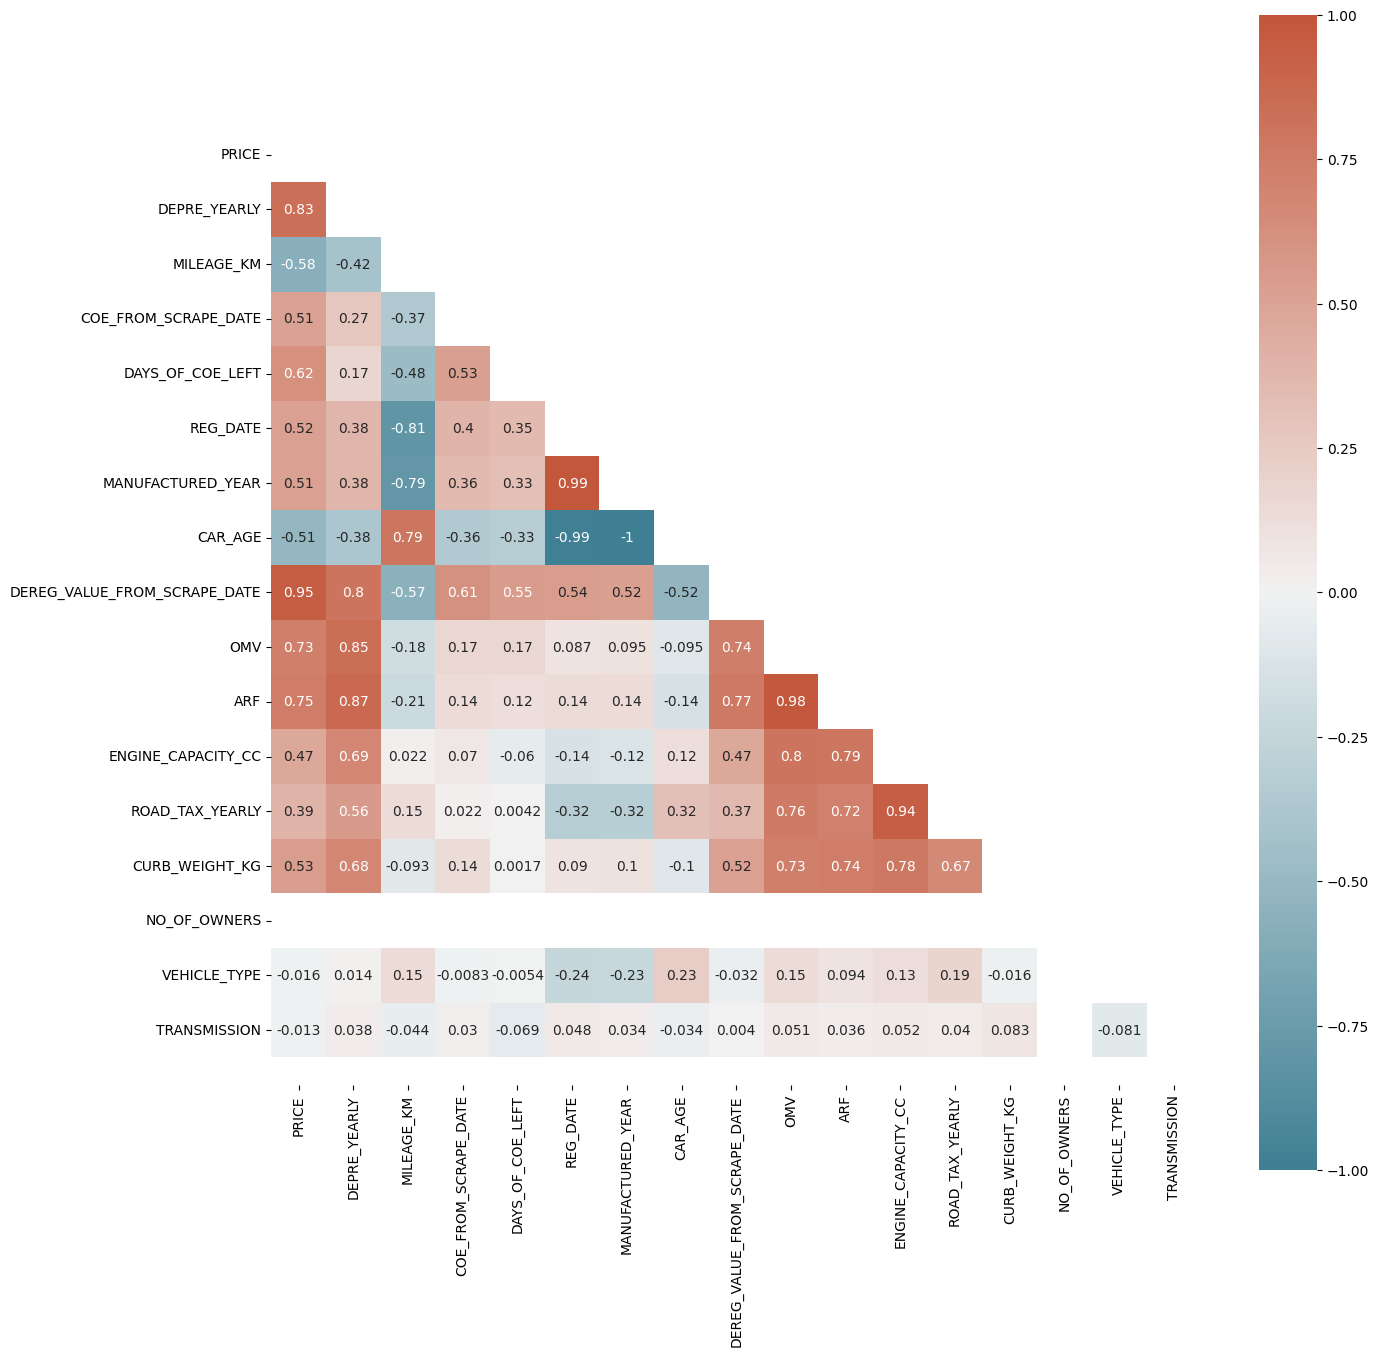

In [103]:
# Corr Matrix Heatmap Visualization

plot_corr_matrix_heatmap(df_price_no_brands)

#### From the above Corr Matrix, we can observe that a few Independent Variables are highly correlated with each other. 
Interestingly, this makes sense due to how a few of the independent variables are calculated. Therefore, some of these features can be dropped.  
1. **OMV and ARF:** 
The Additional Registration Fee (ARF) is a tax imposed upon registration of a vehicle. It is calculated based on a percentage of the Open Market Value (OMV) of the vehicle. From the correlation matrix, they have a correlation of **0.96.** Therefore, we can just keep one of this. Therefore, **ARF** will be dropped.
   
   
2. **Engine CC and Road Tax:** 
Road tax increases as engine CC increases. Therefore, having Road Tax in it would be introducing multicolinearity into the model, since both explain the same thing anyway. From the correlation matrix, they have a correlation of **0.96**. Therefore, **road tax** column will be dropped.
   
   
3. **Manufactured Year and Car Age:** 
Obviously, manufactured year can be dropped, since Car Age is derived from year of manufacture. And since car age is more intuitive, **Manufactured Year** column will be dropped.  From the correlation matrix, they have a correlation of **-1**. 
  

  
4. **Dereg Value:**  
The deregistration value of a vehicle is amount one will get back from the government upon deregistering the vehicle for use in Singapore. It is the sum of the COE rebate and the PARF rebate.
The COE rebate is a percentage of the original COE value.
The PARF rebate is a percentage of the original ARF.
Therefore, the **dereg value will be dropped**. From the corr matrix, ARF and dereg value have a correlation of **0.75.**
  
  
5. **Depreciation:** 
Annual depreciation is the amount the owner loses on the value of the vehicle per year based on the assumption that the vehicle is deregistered only at the end of its 10-yr COE life-span. The value of the car body has not been taken into account.  The formula used to derive the figure is as follows:  
Depreciation = (List Price - Minimum PARF value) ÷ remaining years of COE  
The minimum Preferential Additional Registration Fee (PARF) value is a sum of money that the vehicle owner gets for deregistering his vehicle at the end of its 10-yr COE. It is a function of the Open Market Value (OMV) or Additional Registration Fee (ARF). Commercial vehicles and cars with renewed COE have no minimum PARF value.  Depreciation and ARF have a correlation of **0.88**. **Depreciation** will be dropped.


### Section 3.1.2: Removing Independent Variables with High Correlation to each other

In [104]:
df_price_no_brands = df_price_no_brands.drop(['DEPRE_YEARLY', 'REG_DATE', 'MANUFACTURED_YEAR', 'DEREG_VALUE_FROM_SCRAPE_DATE', 'ARF', 'ROAD_TAX_YEARLY', 'VEHICLE_TYPE'], axis=1)
df_price_no_brands.columns

Index(['PRICE', 'MILEAGE_KM', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'],
      dtype='object')

### Section 3.1.3: Re-Visualizing New Correlation Matrix (with a few features dropped)

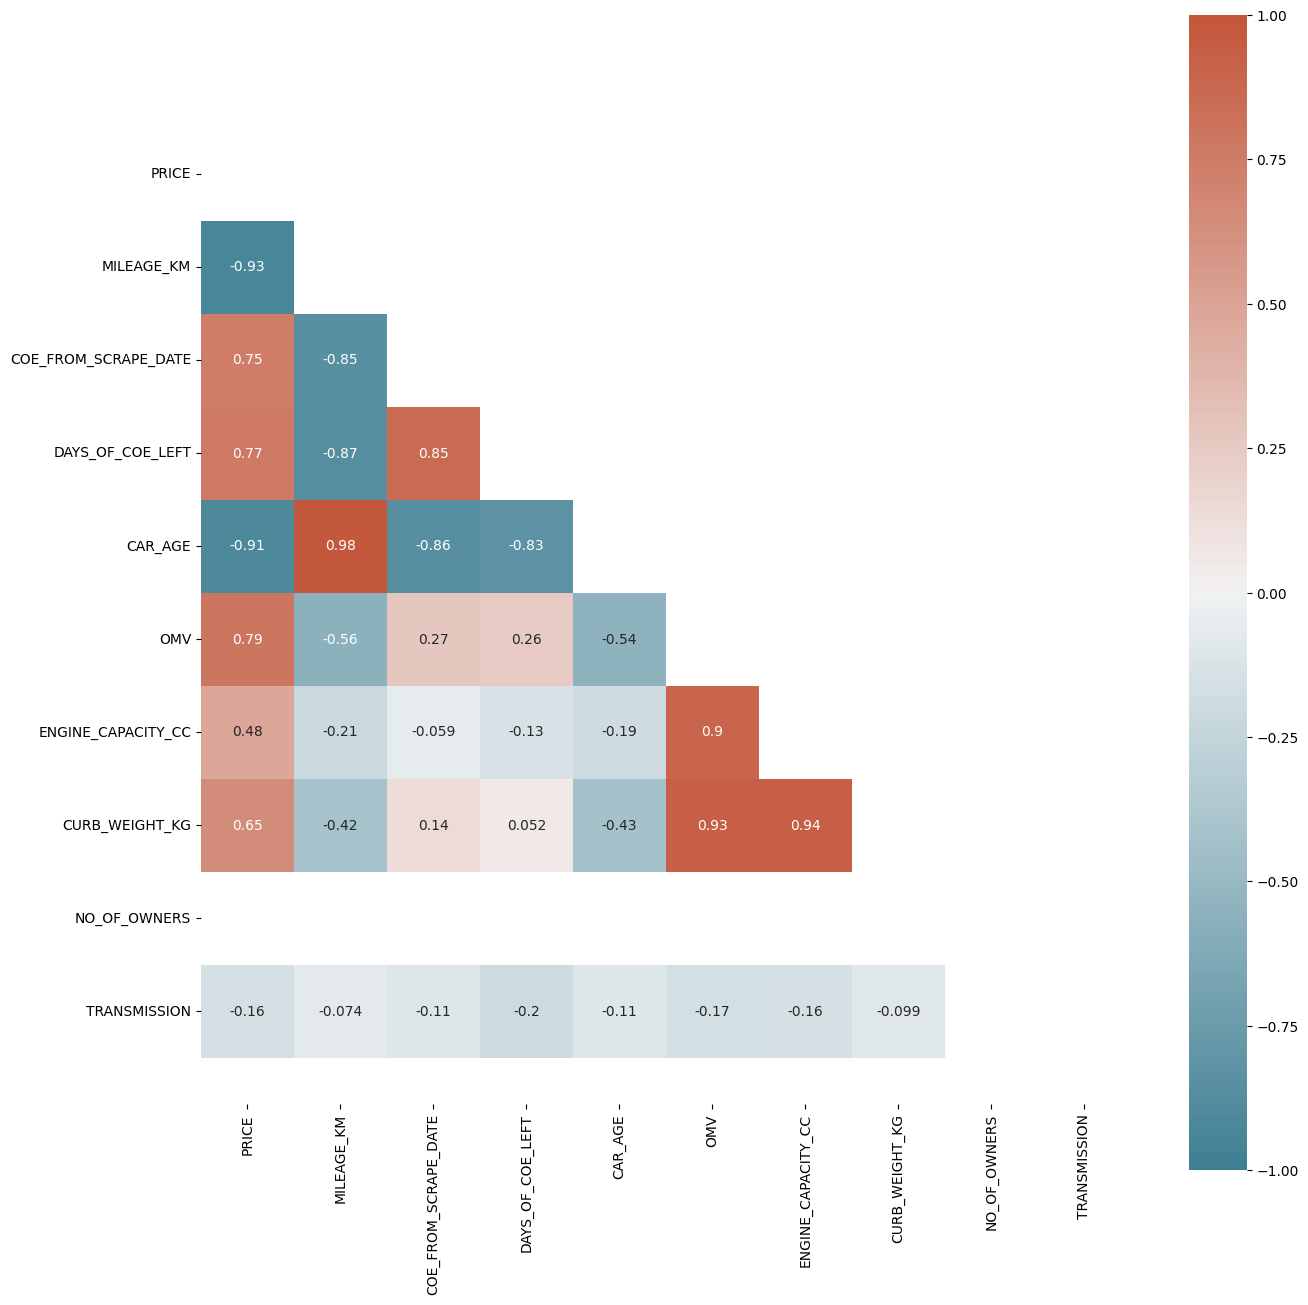

In [105]:
# Re-visualizing the correlation matrix

# Creating the data
data = df_price_no_brands.corr()

plot_corr_matrix_heatmap(data)

In [106]:
# Correlations of the independent variables (features) to dependent variable (target, price)
df_price_no_brands.corr()['PRICE'].sort_values(ascending=False)

PRICE                   1.000000
OMV                     0.732689
DAYS_OF_COE_LEFT        0.621912
CURB_WEIGHT_KG          0.533493
COE_FROM_SCRAPE_DATE    0.505619
ENGINE_CAPACITY_CC      0.469951
TRANSMISSION           -0.013197
CAR_AGE                -0.509111
MILEAGE_KM             -0.579083
NO_OF_OWNERS                 NaN
Name: PRICE, dtype: float64

#### Section 3.1.3.1: Pairplot after Feature Selection

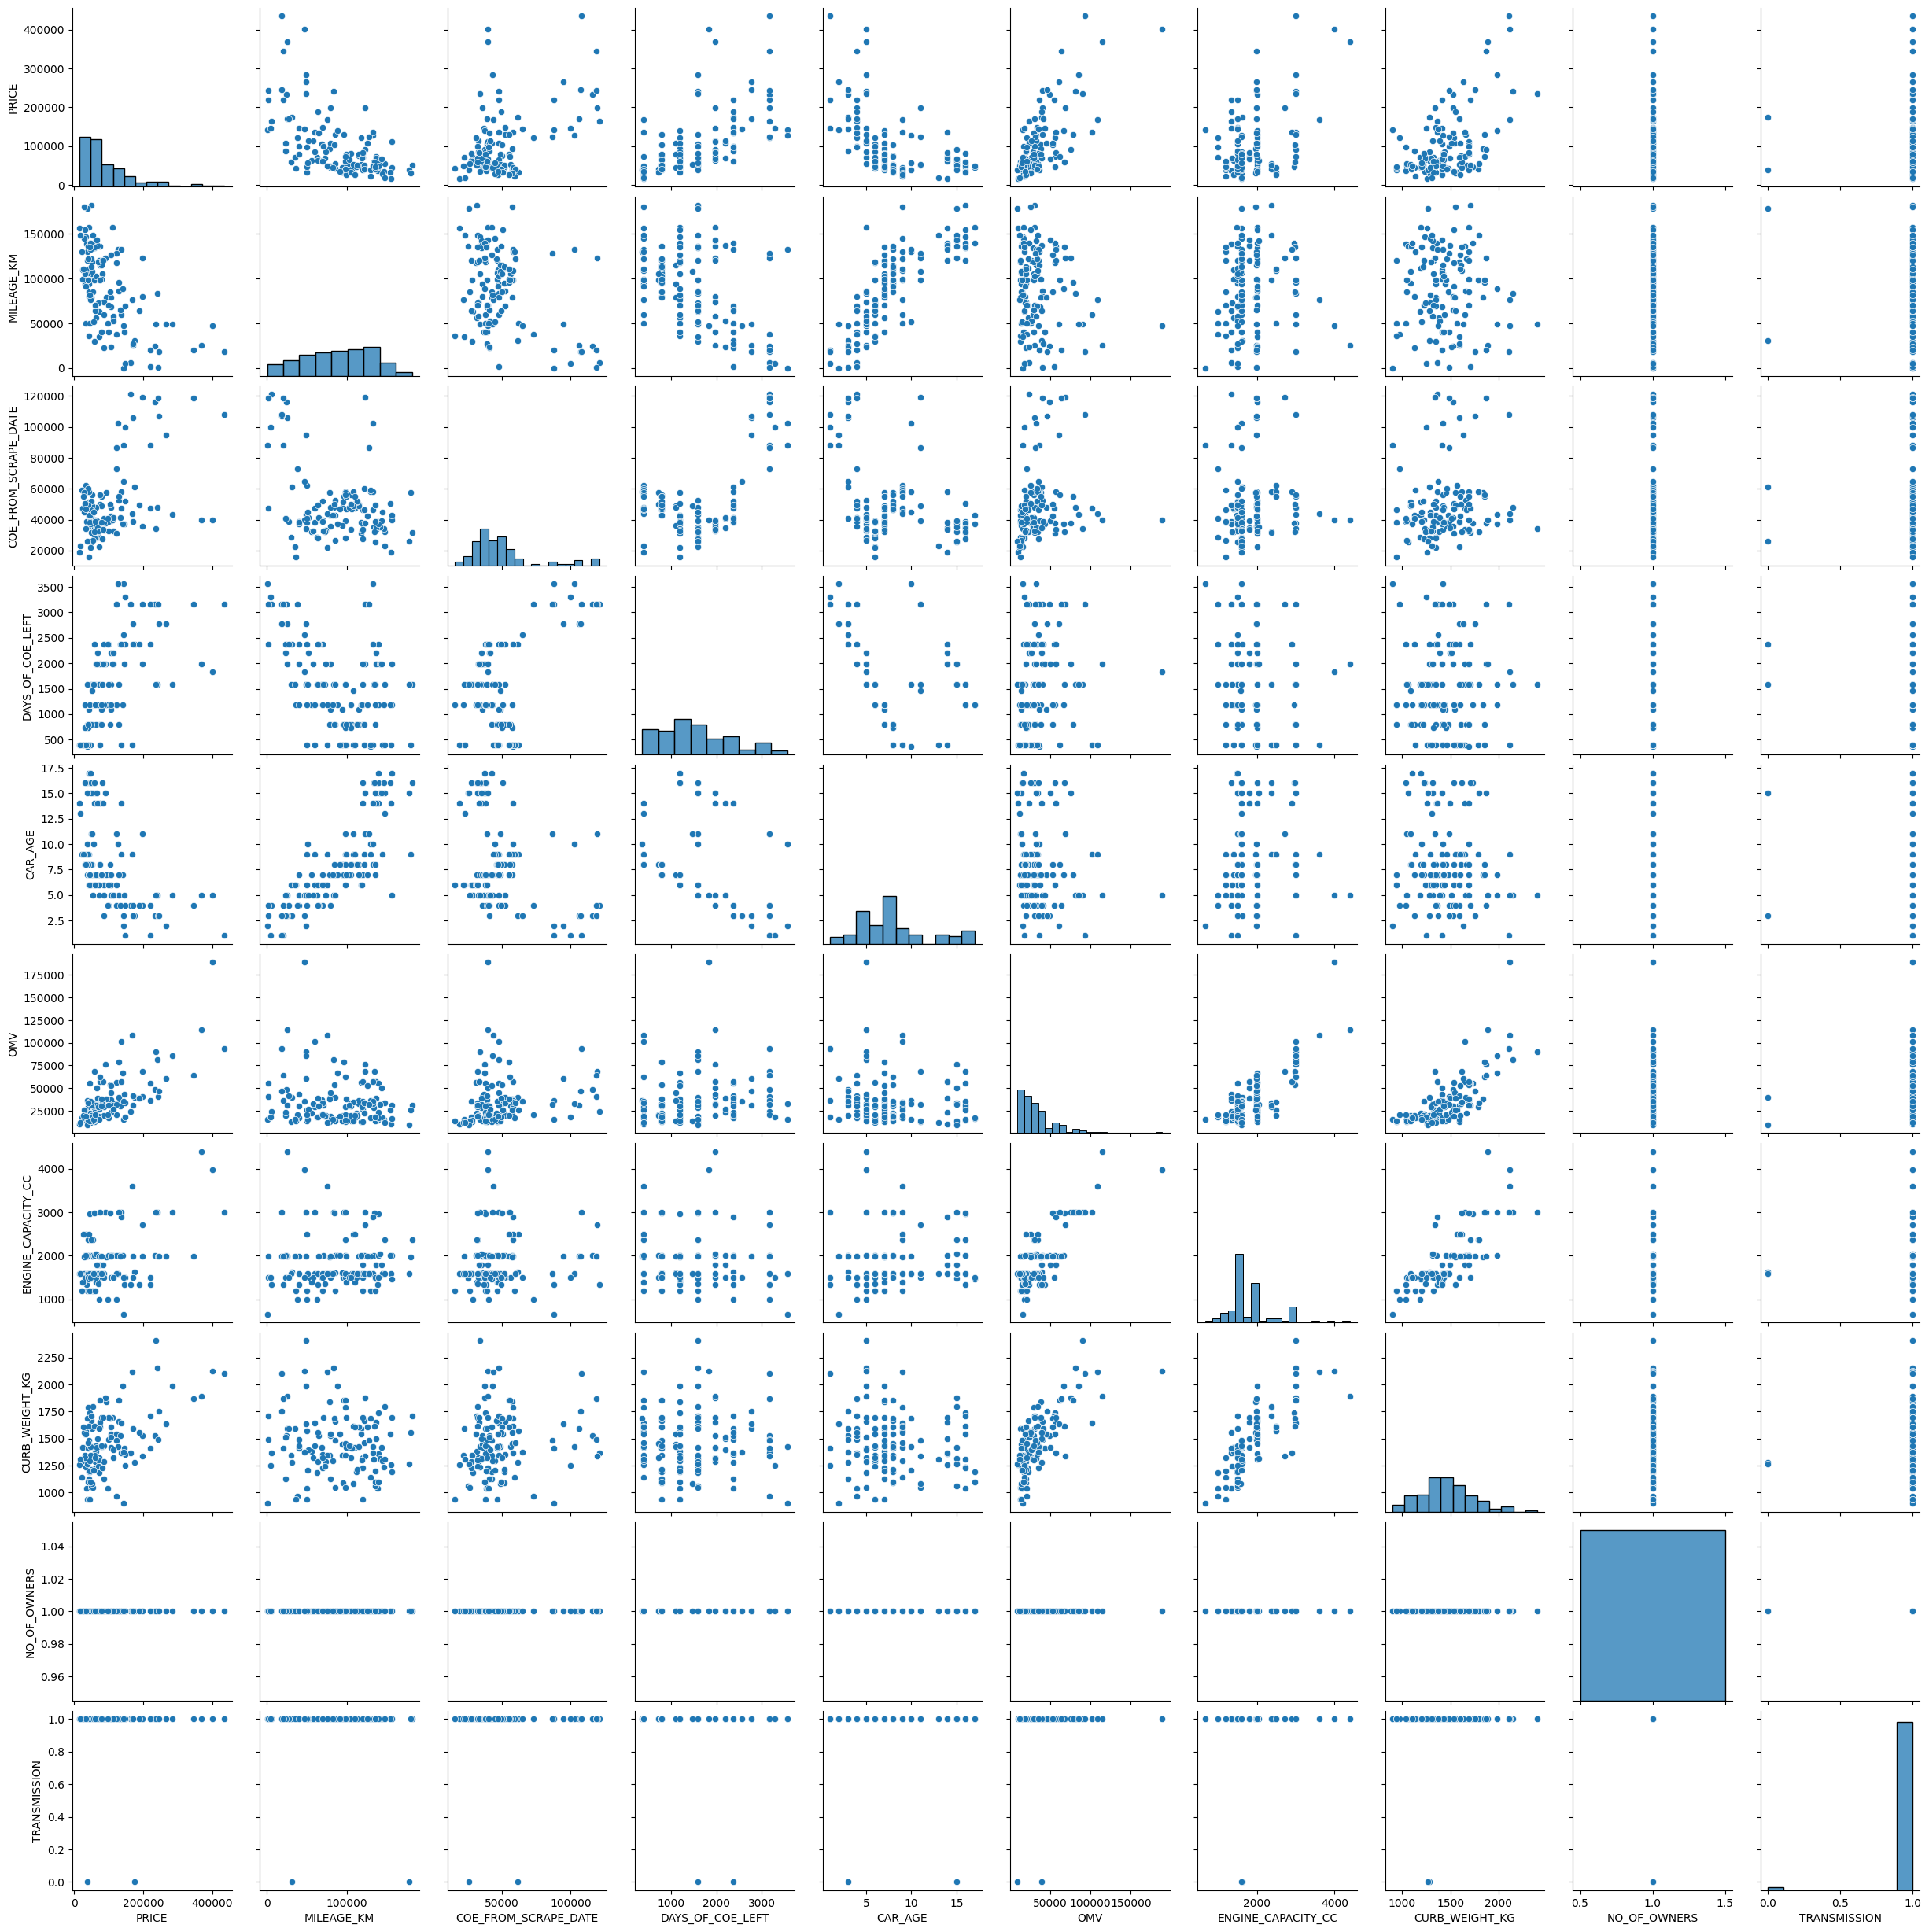

In [107]:
# Performing a pairplot to visualize the data trends of the variables

# We can see that price and mileage hold a negative linear relationship
# COE from the scrape date doesn't seem to have a very clear relatonship here
# Days of COE seems to have a slight linear r/s
# Car age doesn't seem to have a very distinct relationship here. But generally, the younger the car, the higher the price
# OMV has a clear increasing linear rs with price with price
# Engine capacity seems to also have a increasing linear r/s  with price, with a few outliers in the center
# Perhaps it's because a lot of the higher-priced cars (higher brands) are produced in that engine capacity range?
# Curb weight seems to have a linear r/s too.

sns.pairplot(df_price_no_brands);

In [108]:
df_price_no_brands.columns

Index(['PRICE', 'MILEAGE_KM', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'],
      dtype='object')

### Section 3.2: Preliminary Model fitting to check R^2 Value and P>|t| values of Price and the leftover Independent Variables

In [109]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_price_no_brands[ ['MILEAGE_KM', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'] ].astype(float)
X = sm.add_constant(X)
Y = df_price_no_brands['PRICE'].astype(float)



In [110]:
X.head()

,MILEAGE_KM,COE_FROM_SCRAPE_DATE,DAYS_OF_COE_LEFT,CAR_AGE,OMV,ENGINE_CAPACITY_CC,CURB_WEIGHT_KG,NO_OF_OWNERS,TRANSMISSION
0,5600.0,121000.0,3168.0,4.0,24155.0,1332.0,1365.0,1.0,1.0
1,68500.0,39401.0,1584.0,6.0,37248.0,1499.0,1415.0,1.0,1.0
3,31000.0,61190.0,2376.0,3.0,39511.0,1618.0,1280.0,1.0,0.0
4,85900.0,52502.0,1584.0,5.0,40167.0,1998.0,1660.0,1.0,1.0
6,105000.0,56206.0,792.0,8.0,29860.0,1499.0,1425.0,1.0,1.0


In [111]:
Y.head()

0    163800.0
1    105800.0
3    174888.0
4    129800.0
6     51988.0
Name: PRICE, dtype: float64

In [112]:
# model / fit / summarize
print(linear_regression_analysis(X, Y))

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     125.4
Date:                Mon, 09 Sep 2024   Prob (F-statistic):           1.49e-54
Time:                        21:40:55   Log-Likelihood:                -1493.4
No. Observations:                 129   AIC:                             3005.
Df Residuals:                     120   BIC:                             3031.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
MILEAGE_KM              -0.1280 

In [113]:
print(random_forest_analysis(X, Y))

{'RMSE': 10129.881762471574, 'R^2': 0.9835231781719909}


### Section 3.2.1: Optimizing R^2 Value

#### Section 3.2.1.1: Checking Distributions & Pairplots of all Variables

##### Pairplot of Price vs Independent Variables (without any transformation)

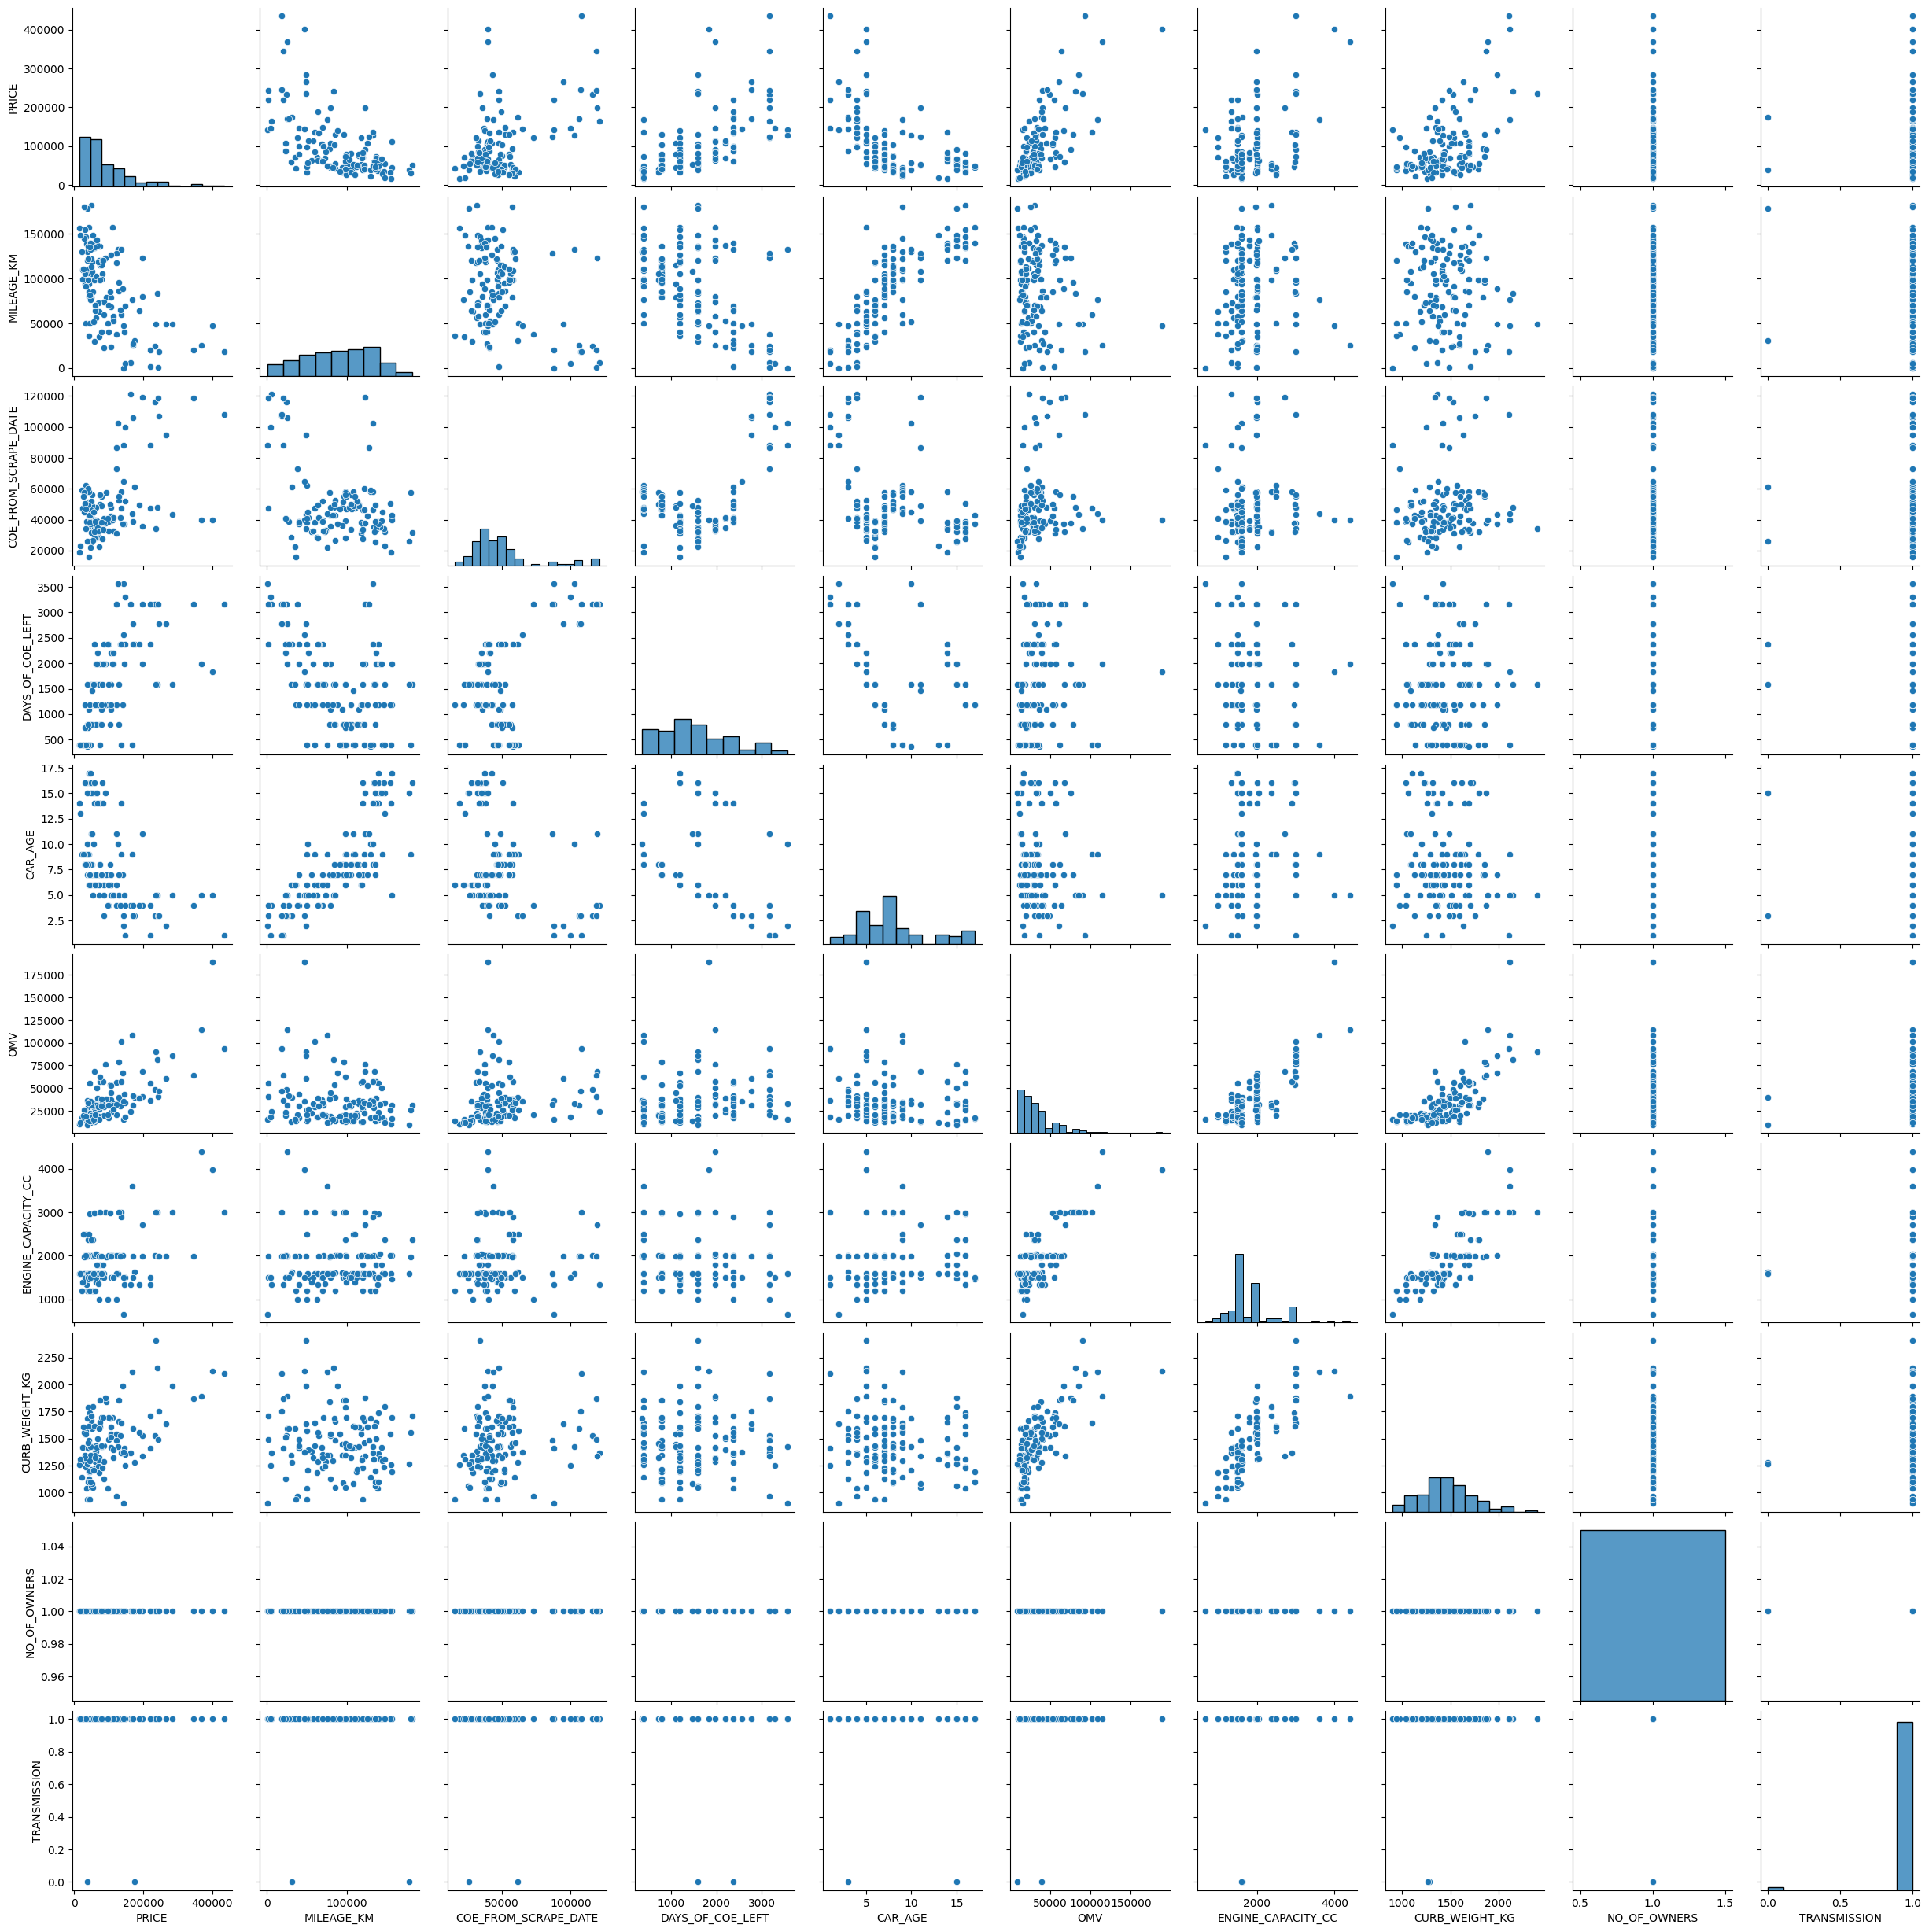

In [114]:
# Performing a pairplot to visualize the data trends of the variables

# We can see that price and mileage hold a negative linear relationship
# COE from the scrape date doesn't seem to have a very clear relatonship here
# Days of COE seems to have a slight linear r/s
# Car age doesn't seem to have a very distinct relationship here. But generally, the younger the car, the higher the price
# OMV has a clear increasing linear rs with price with price
# Engine capacity seems to also have a increasing linear r/s  with price, with a few outliers in the center
# Perhaps it's because a lot of the higher-priced cars (higher brands) are produced in that engine capacity range?
# Curb weight seems to have a linear r/s too.

sns.pairplot(df_price_no_brands);

##### Histograph of all Variables (Columns) in DataFrame

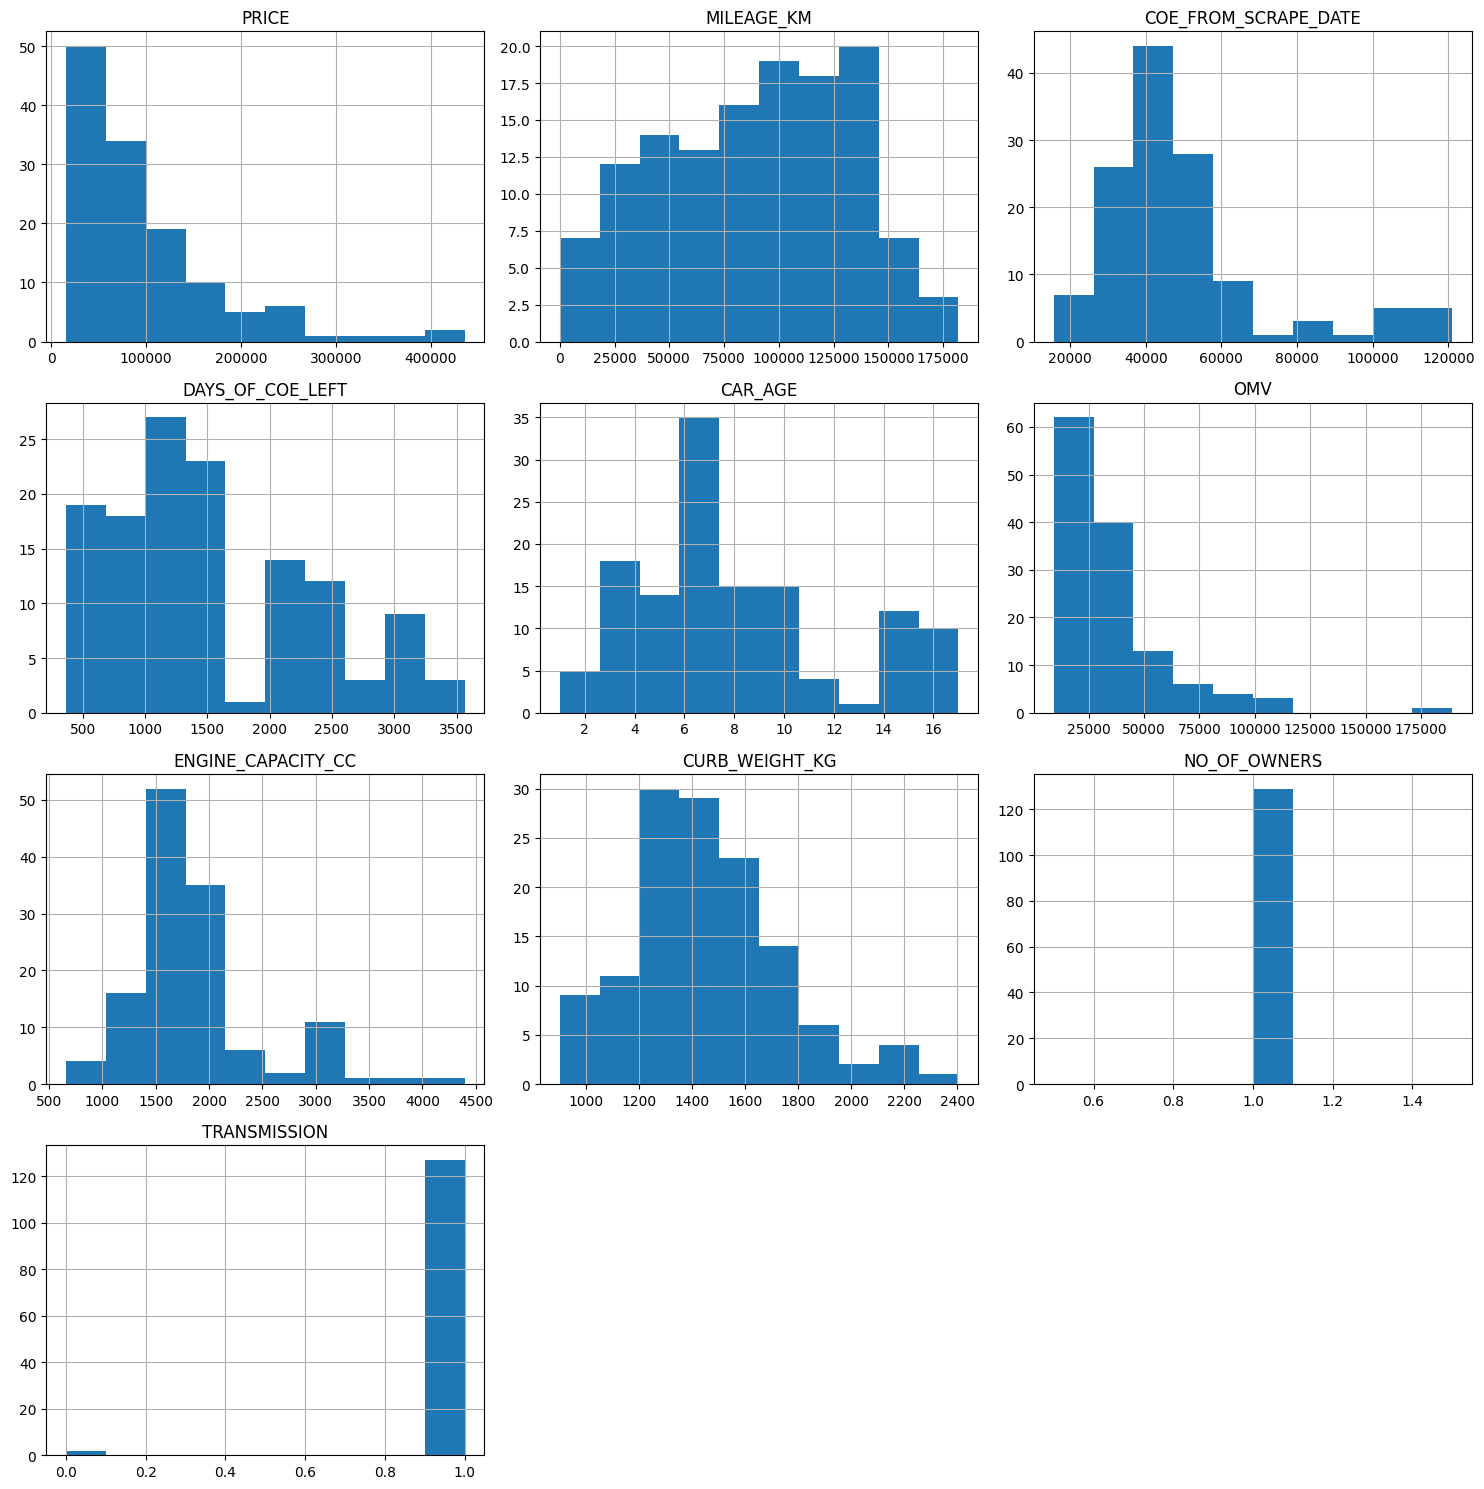

In [115]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(df_price_no_brands.columns):
    df_price_no_brands[col].hist(ax=axes[i])
    axes[i].set_title(col)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

From the above graphs, it would make sense to apply log transform on the following variables to make them
* more normally distributed
* Mileage
* Engine Cap
* Price
* OMV

## Distribution of Price

<Axes: ylabel='PRICE'>

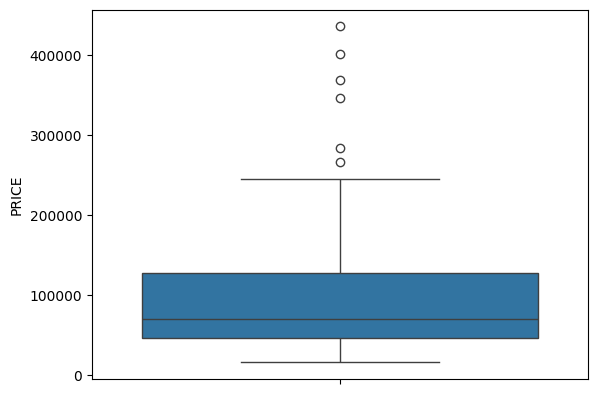

In [116]:
sns.boxplot(df_price_no_brands['PRICE'])  # 

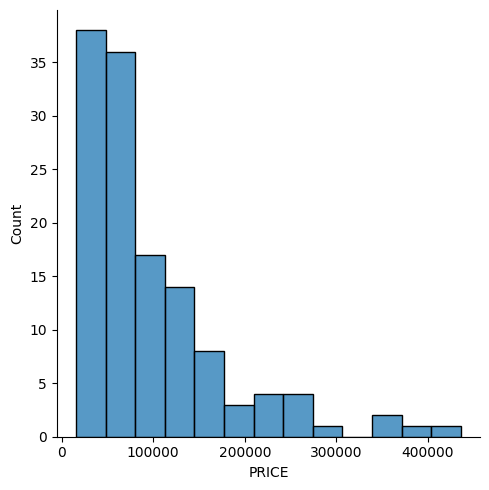

In [117]:
sns.displot(df_price_no_brands['PRICE'])  # Your dependent variable 'must' be normally distributed

We see that price is right-skewed. Therefore, we can try applying a log onto price, then visualize the data again.

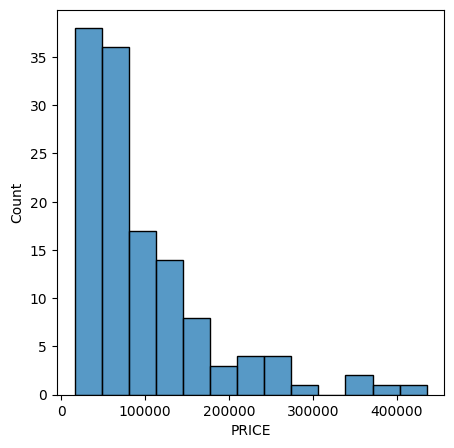

In [118]:
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(df_price_no_brands['PRICE'],ax=ax)
plt.xlabel('PRICE',size=10)
plt.savefig("price_no_log.png",transparent=True)

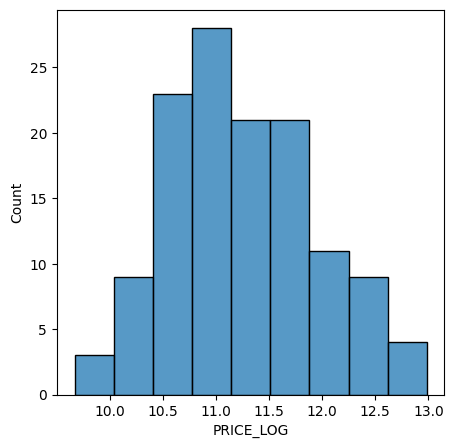

In [119]:
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(np.log(df_price_no_brands['PRICE']),ax=ax)
plt.xlabel("PRICE_LOG",size=10)
plt.savefig("price_log.png",transparent=True)

### Section 3.2.1: Logging Mileage ONLY

In [120]:
# Creating a copy of the dataframe to work log on
df_price_no_brands_only_mileage_logged = df_price_no_brands.copy()

In [121]:
# Log Mileage
df_price_no_brands_only_mileage_logged["MILEAGE_LOG"] = df_price_no_brands_only_mileage_logged['MILEAGE_KM'].apply(np.log)
df_price_no_brands_only_mileage_logged

,PRICE,MILEAGE_KM,COE_FROM_SCRAPE_DATE,DAYS_OF_COE_LEFT,CAR_AGE,OMV,ENGINE_CAPACITY_CC,CURB_WEIGHT_KG,NO_OF_OWNERS,TRANSMISSION,MILEAGE_LOG
0,163800,5600.0,121000.0,3168,4.0,24155.0,1332.0,1365.0,1,1,8.630522
1,105800,68500.0,39401.0,1584,6.0,37248.0,1499.0,1415.0,1,1,11.134589
3,174888,31000.0,61190.0,2376,3.0,39511.0,1618.0,1280.0,1,0,10.341742
4,129800,85900.0,52502.0,1584,5.0,40167.0,1998.0,1660.0,1,1,11.360939
6,51988,105000.0,56206.0,792,8.0,29860.0,1499.0,1425.0,1,1,11.561716
...,...,...,...,...,...,...,...,...,...,...,...
192,97800,50000.0,40556.0,2376,4.0,21038.0,996.0,1040.0,1,1,10.819778
193,143800,47000.0,64700.0,2562,3.0,35415.0,1499.0,1375.0,1,1,10.757903
194,345800,20000.0,118501.0,3168,4.0,63673.0,1984.0,1870.0,1,1,9.903488
195,33600,91500.0,47000.0,396,8.0,18499.0,1999.0,1540.0,1,1,11.424094


In [122]:
# Rearranging columns

df_price_no_brands_only_mileage_logged = \
df_price_no_brands_only_mileage_logged[['PRICE', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION']]

In [123]:
df_price_no_brands_only_mileage_logged.columns

Index(['PRICE', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'],
      dtype='object')

In [124]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_price_no_brands_only_mileage_logged[ ['MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'] ].astype(float)
Y = df_price_no_brands_only_mileage_logged['PRICE'].astype(float)


# model / fit / summarize
print(linear_regression_analysis(X, Y))

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     124.0
Date:                Mon, 09 Sep 2024   Prob (F-statistic):           2.78e-54
Time:                        21:41:20   Log-Likelihood:                -1494.1
No. Observations:                 129   AIC:                             3006.
Df Residuals:                     120   BIC:                             3032.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
MILEAGE_LOG          -2035.2665 

In [125]:
print(random_forest_analysis(X, Y))

{'RMSE': 10144.959062234768, 'R^2': 0.9834740935200489}


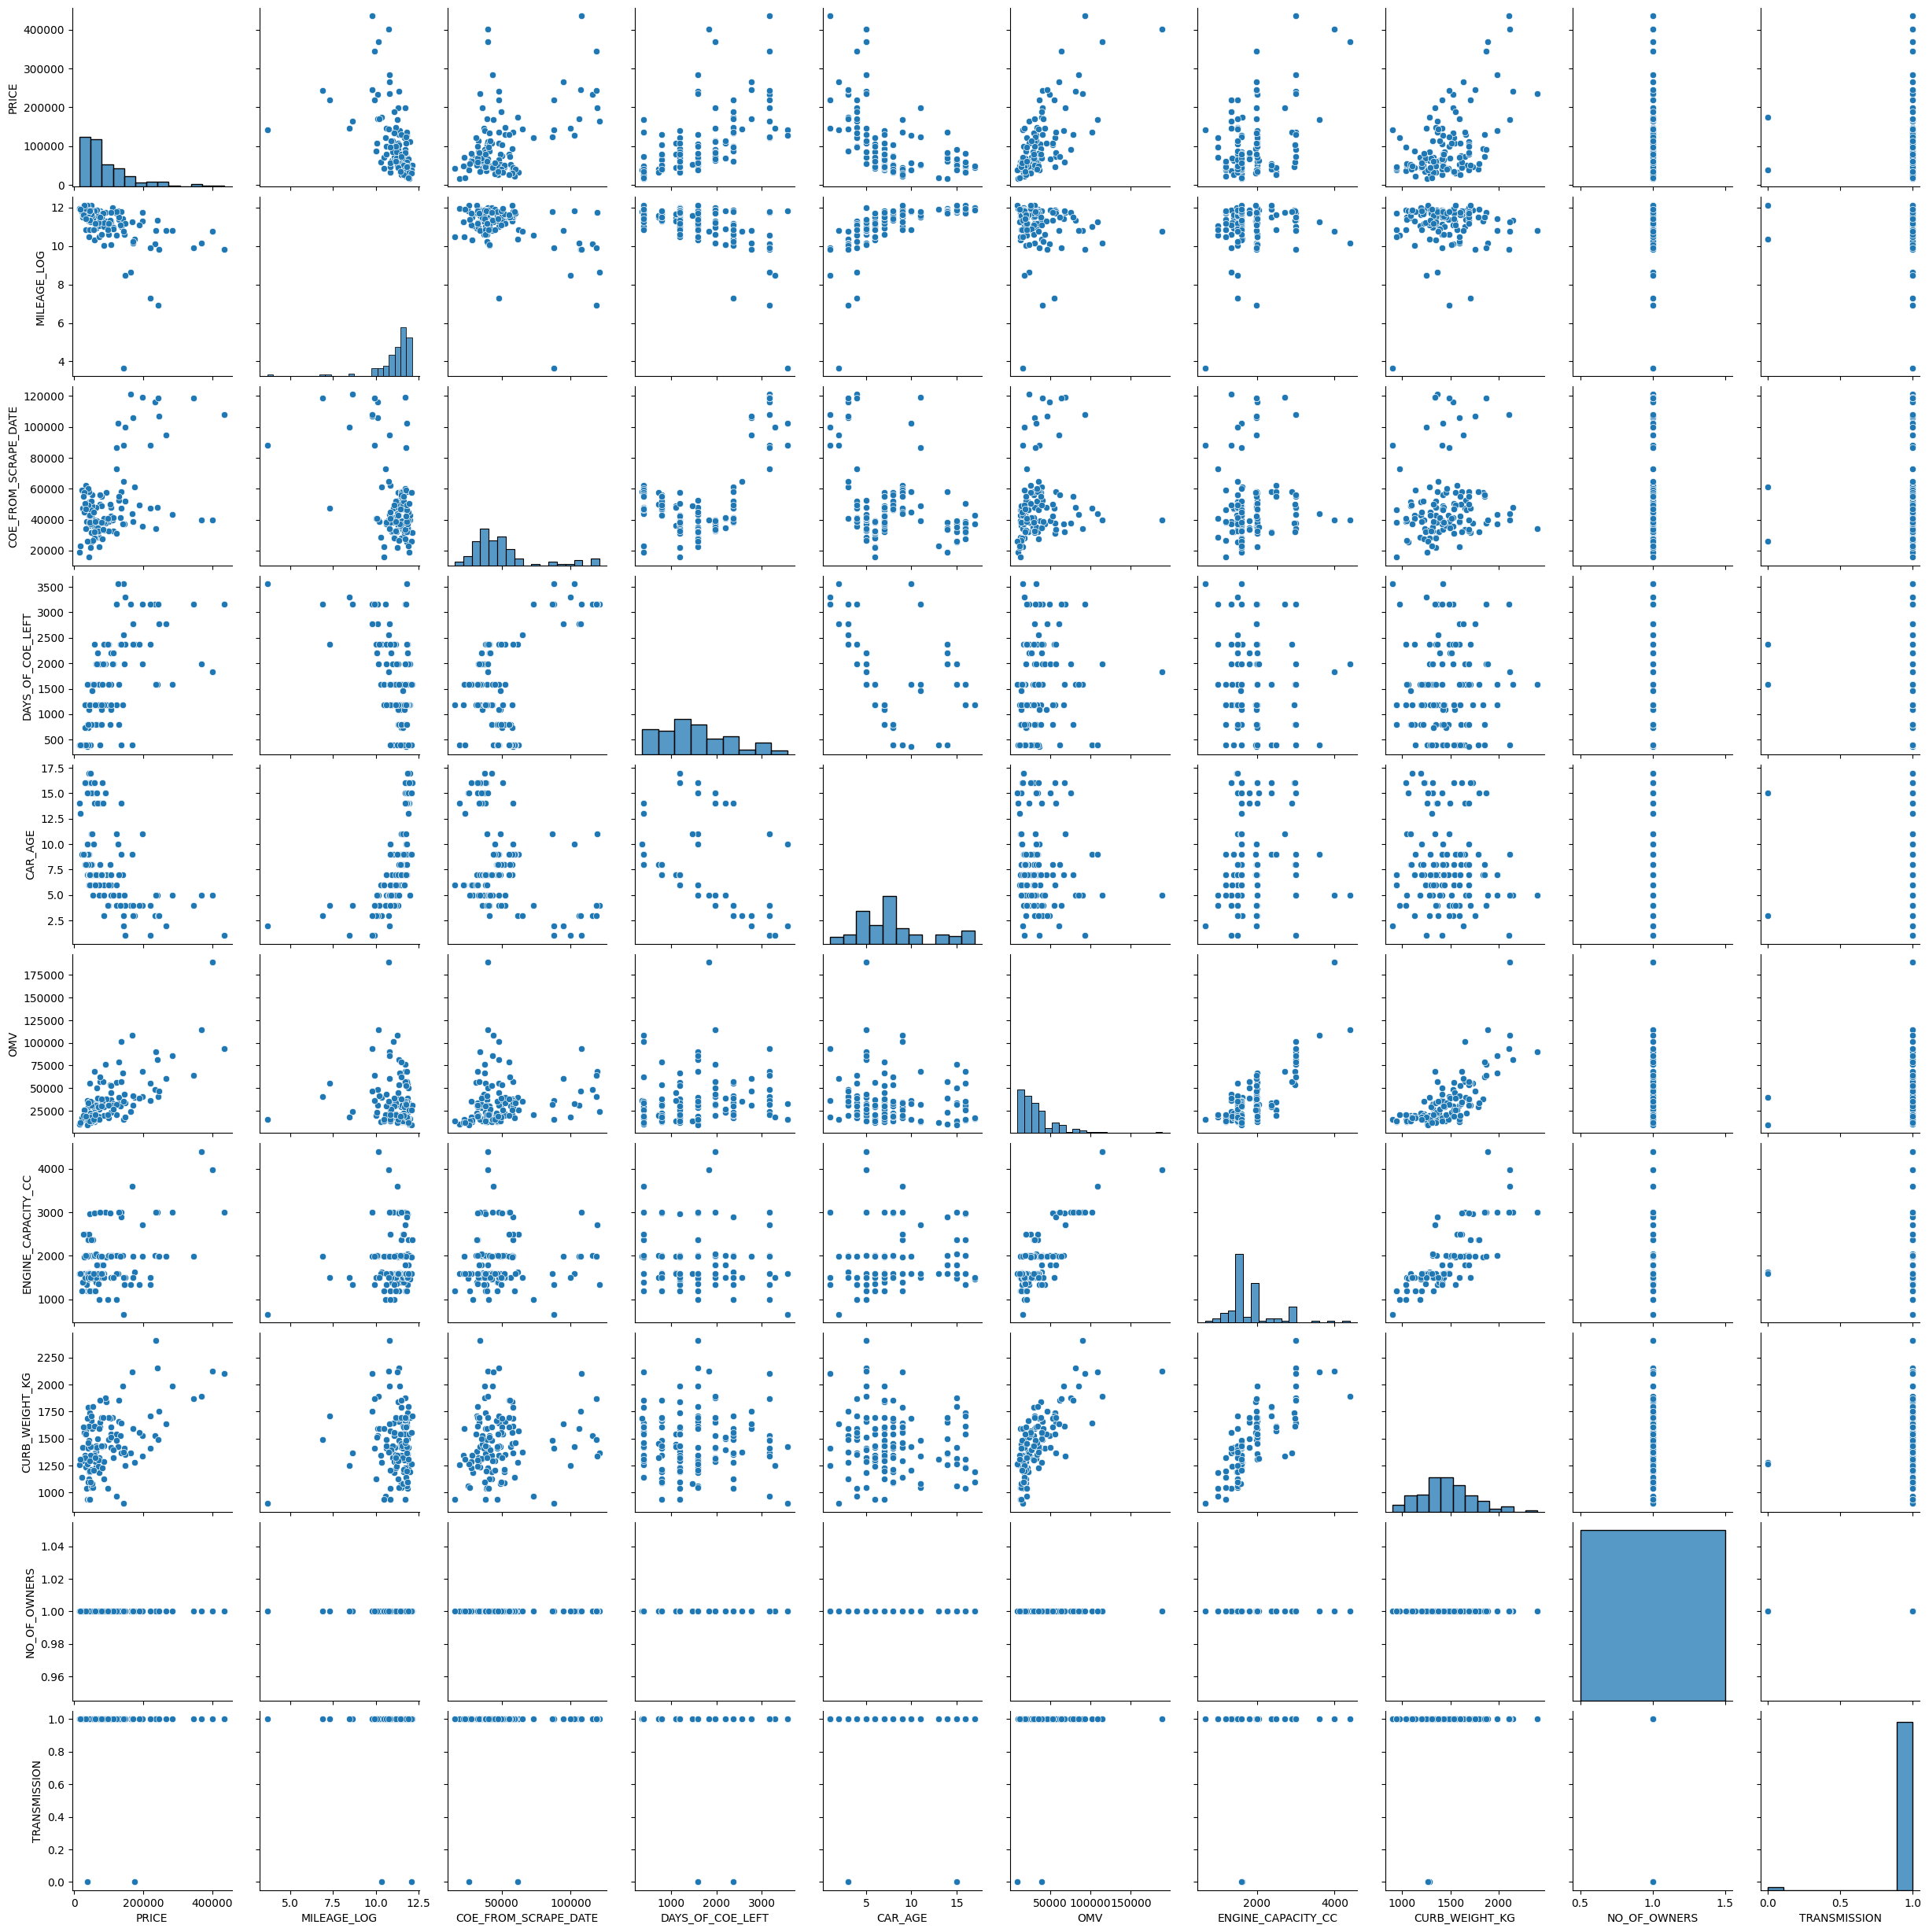

In [126]:
# Visualizing Pairplots of Price vs Other Features and Only Mileage logged

sns.pairplot(df_price_no_brands_only_mileage_logged);

### Section 3.2.2: Normal Price with Logged Mileage and Squared Engine CC

In [127]:
# Creating a copy of the dataframe to work log on
df_price_no_brands_mileage_logged_squared_engine_cap = df_price_no_brands_only_mileage_logged.copy()

In [128]:
# Square Engine CC
df_price_no_brands_mileage_logged_squared_engine_cap["ENGINE_SQUARED"] = \
df_price_no_brands_mileage_logged_squared_engine_cap['ENGINE_CAPACITY_CC'].apply(lambda x: x**2)

In [129]:
df_price_no_brands_mileage_logged_squared_engine_cap.columns

Index(['PRICE', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION', 'ENGINE_SQUARED'],
      dtype='object')

In [130]:
# Rearrange columns
df_price_no_brands_mileage_logged_squared_engine_cap = \
df_price_no_brands_mileage_logged_squared_engine_cap[['PRICE', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_SQUARED', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION']]

In [131]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_price_no_brands_mileage_logged_squared_engine_cap[ ['MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_SQUARED', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'] ].astype(float)
Y = df_price_no_brands_only_mileage_logged['PRICE'].astype(float)


# model / fit / summarize
print(linear_regression_analysis(X, Y))

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     124.9
Date:                Mon, 09 Sep 2024   Prob (F-statistic):           1.87e-54
Time:                        21:41:38   Log-Likelihood:                -1493.7
No. Observations:                 129   AIC:                             3005.
Df Residuals:                     120   BIC:                             3031.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
MILEAGE_LOG          -1730.4677 

In [132]:
print(random_forest_analysis(X, Y))

{'RMSE': 10166.26780992392, 'R^2': 0.9834045976850717}


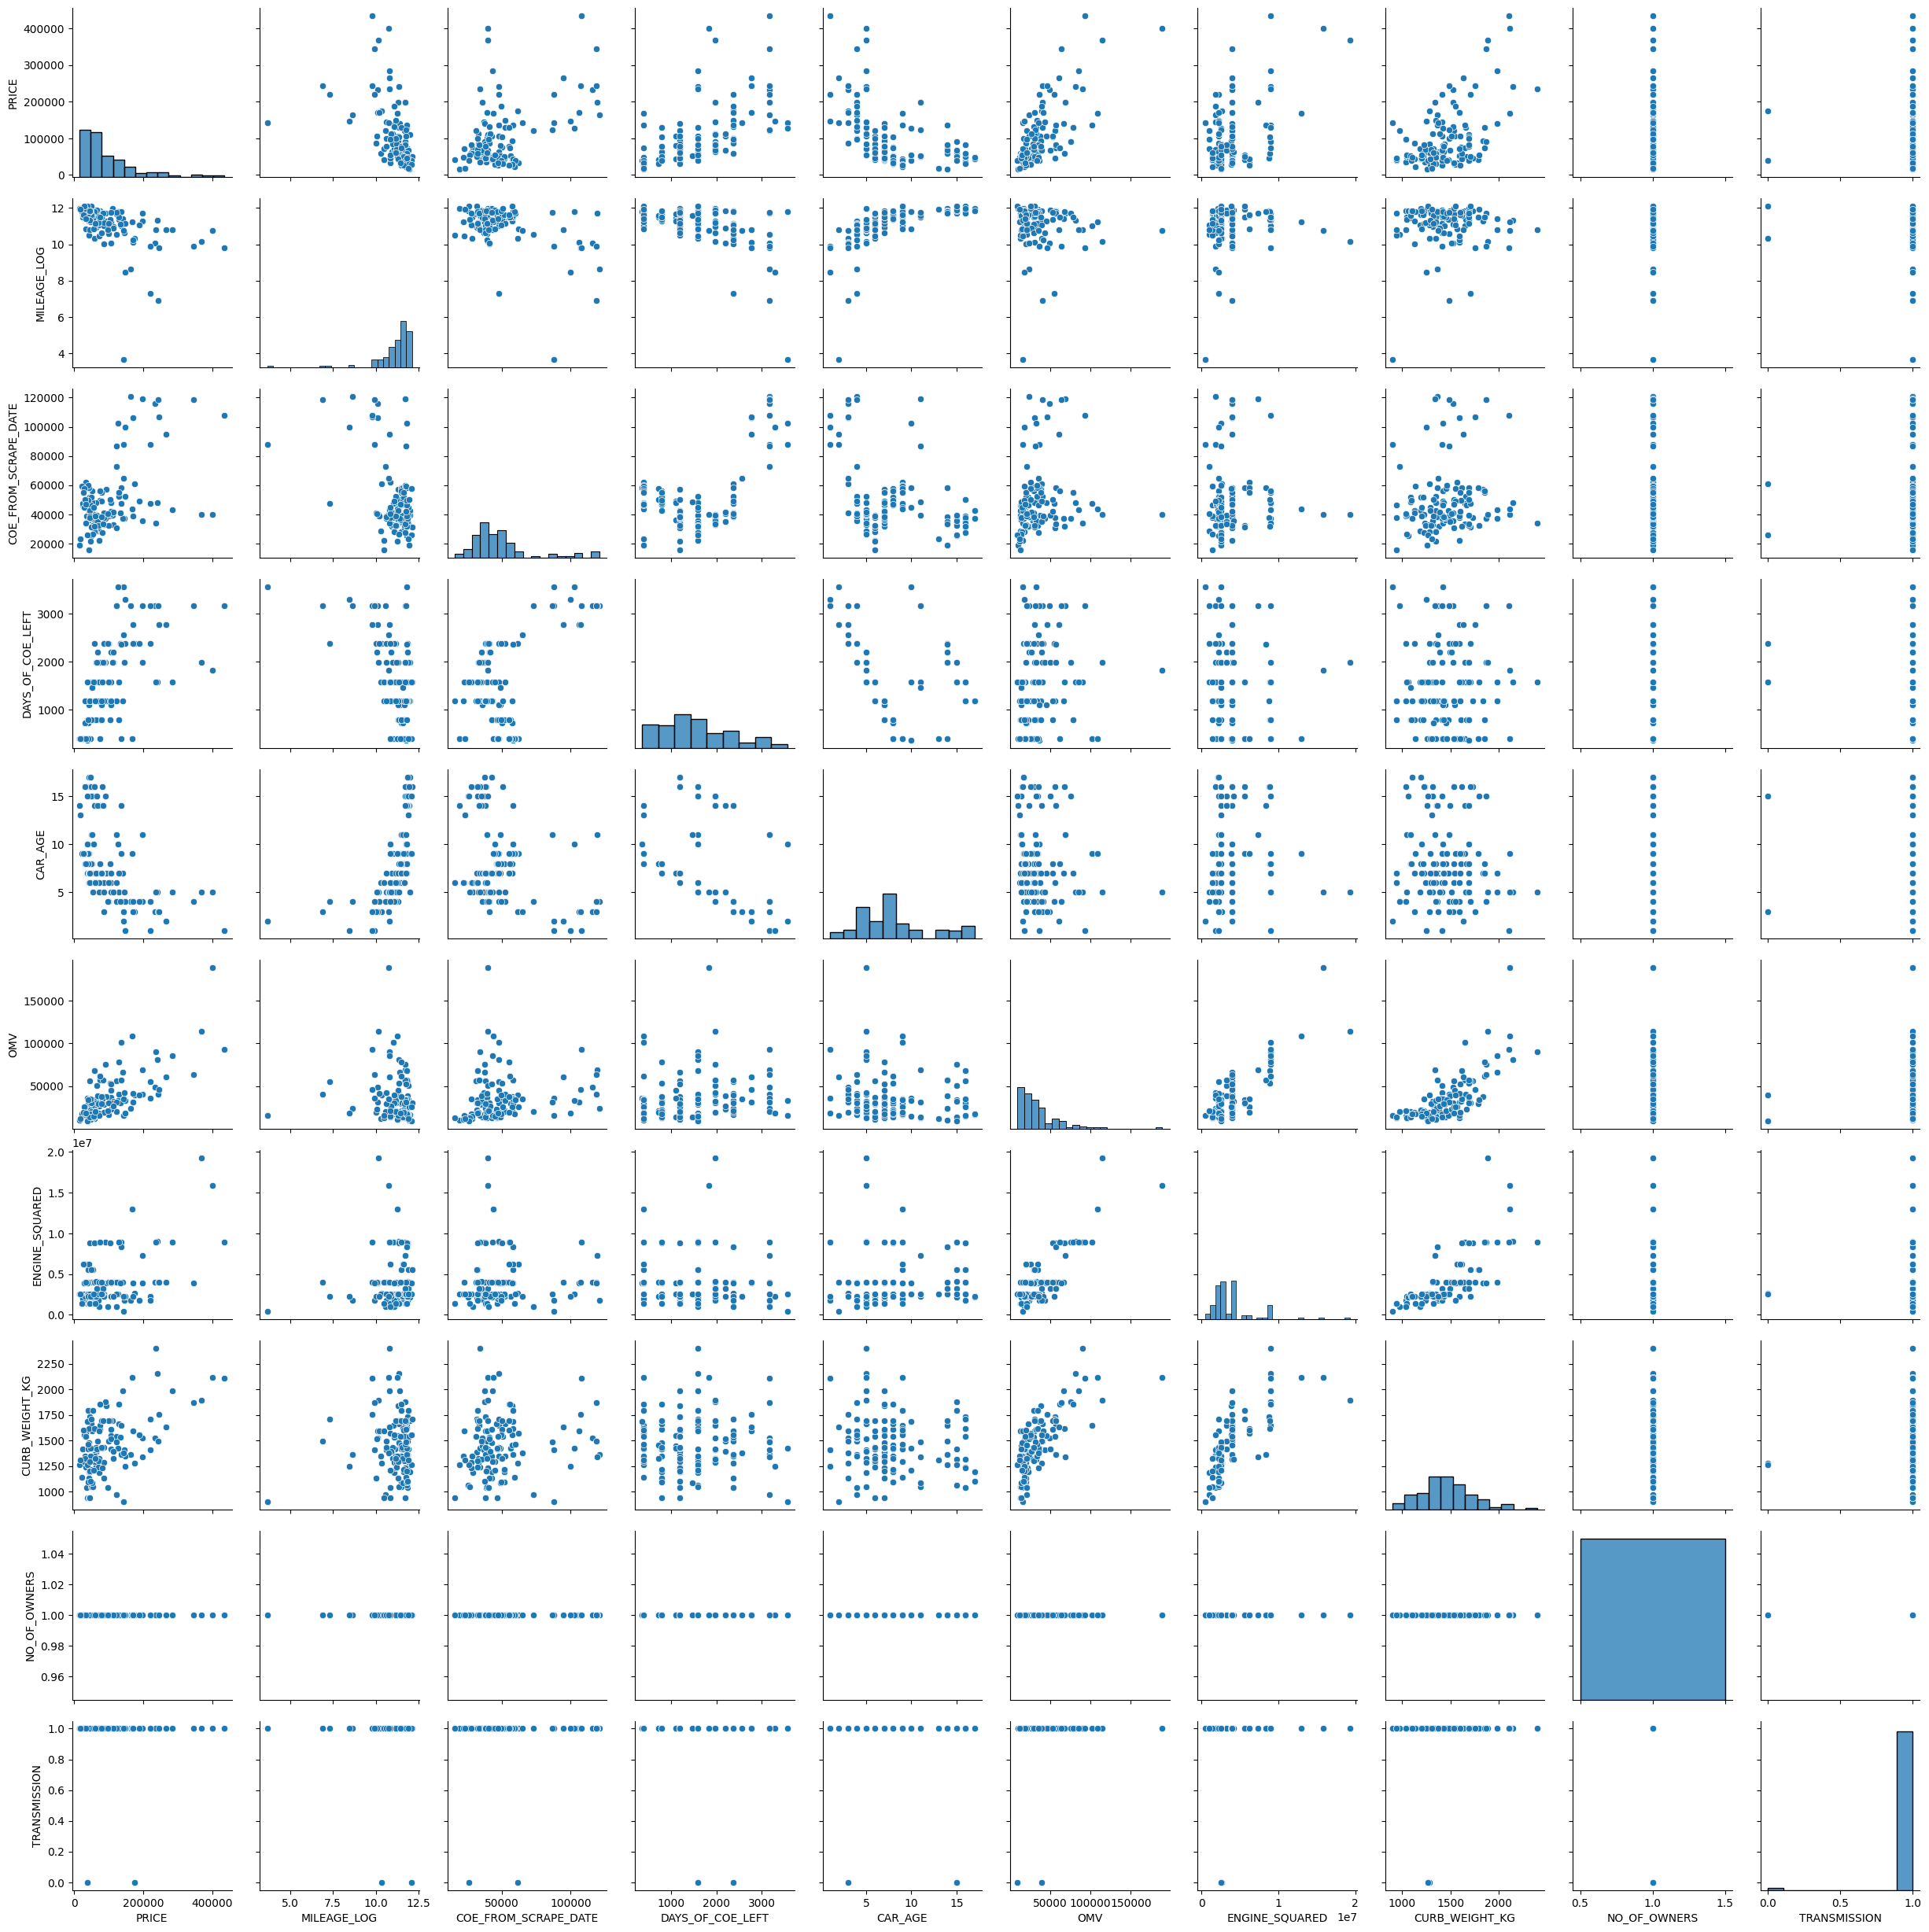

In [133]:
# Visualizing Pairplots of the distributions

sns.pairplot(df_price_no_brands_mileage_logged_squared_engine_cap);

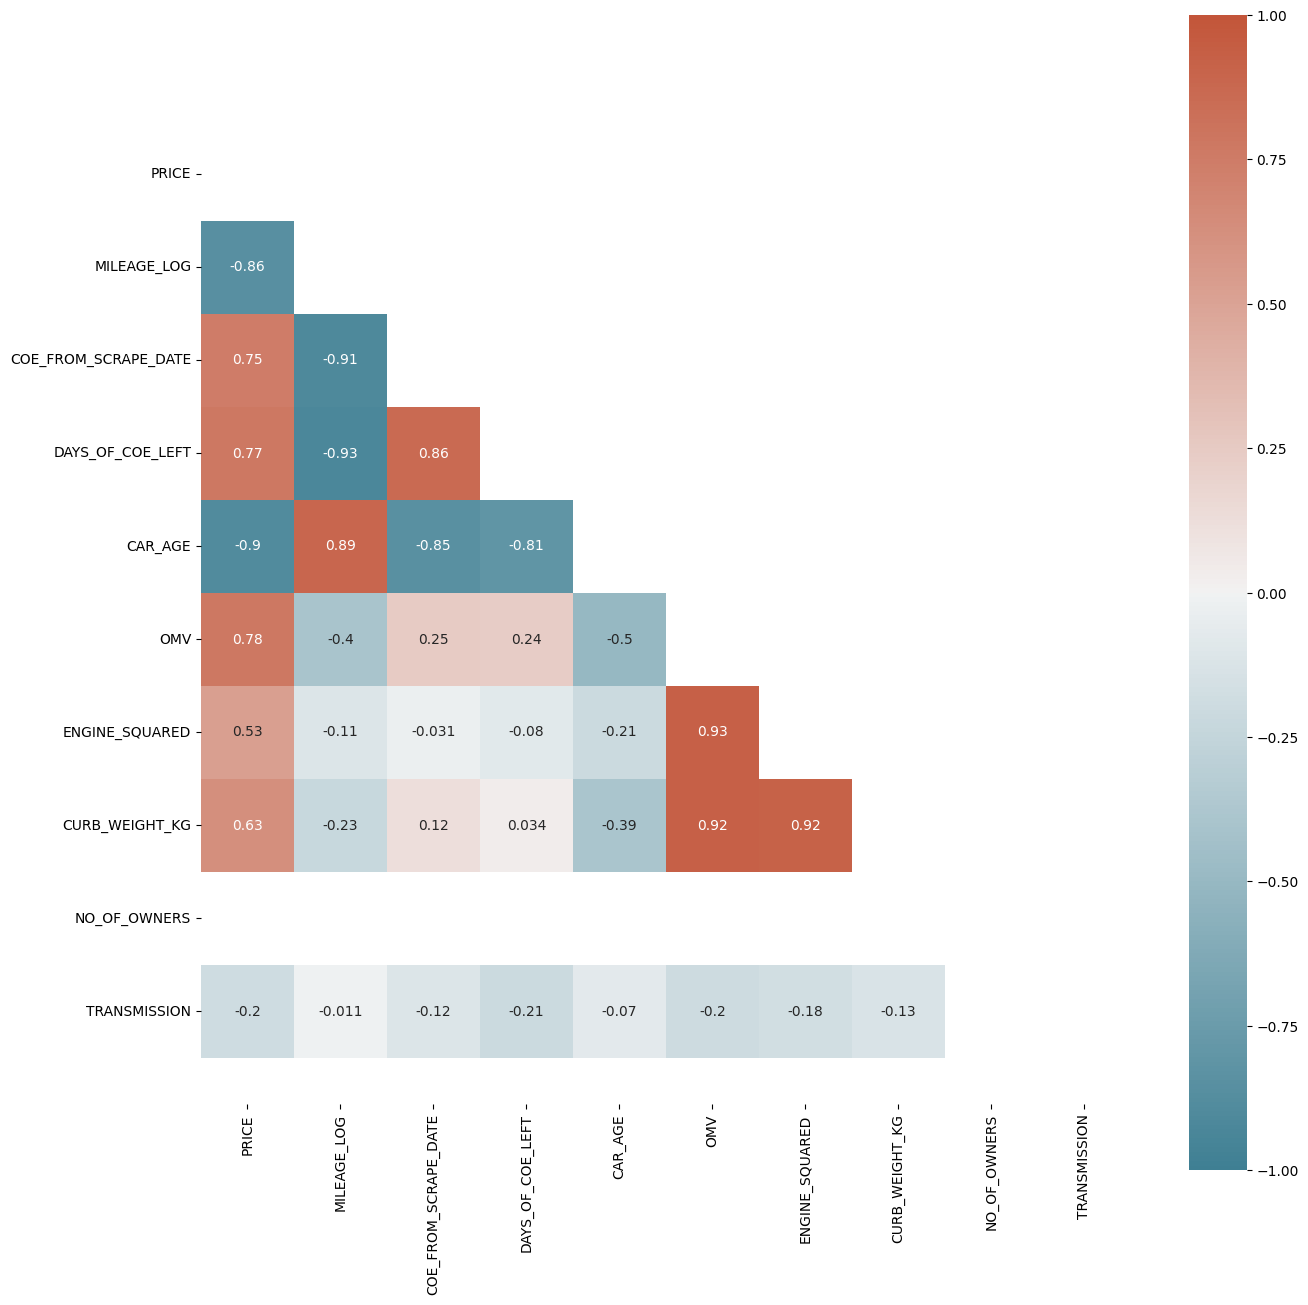

In [134]:
# Viewing Corr Matrix of Price vs Independent Variables (only logged mileage and squared engine CC)

data = df_price_no_brands_mileage_logged_squared_engine_cap.corr()

plot_corr_matrix_heatmap(data)

### Section 3.2.3: Logged Price with Logged Mileage and Squared Engine CC

In [135]:
df_logged_price_no_brands_mileage_logged_squared_engine_cap = df_price_no_brands_mileage_logged_squared_engine_cap.copy()

In [136]:
# Logging Price
df_logged_price_no_brands_mileage_logged_squared_engine_cap['PRICE_LOG'] =\
df_logged_price_no_brands_mileage_logged_squared_engine_cap['PRICE'].apply(np.log)

In [137]:
# Rearrange columns
df_logged_price_no_brands_mileage_logged_squared_engine_cap = \
df_logged_price_no_brands_mileage_logged_squared_engine_cap[['PRICE_LOG', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_SQUARED', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION']]

In [138]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_logged_price_no_brands_mileage_logged_squared_engine_cap[ ['MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_SQUARED', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'] ].astype(float)
Y = df_logged_price_no_brands_mileage_logged_squared_engine_cap['PRICE_LOG'].astype(float)


# model / fit / summarize
print(linear_regression_analysis(X, Y))

                            OLS Regression Results                            
Dep. Variable:              PRICE_LOG   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     168.9
Date:                Mon, 09 Sep 2024   Prob (F-statistic):           1.54e-61
Time:                        21:42:00   Log-Likelihood:                 26.711
No. Observations:                 129   AIC:                            -35.42
Df Residuals:                     120   BIC:                            -9.684
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
MILEAGE_LOG              0.0077 

In [139]:
print(random_forest_analysis(X, Y))

{'RMSE': 0.07446831576066701, 'R^2': 0.9883077839532844}


### Section 3.2.3: Logged Price with Logged Mileage only (no engine squared)

In [140]:
df_logged_price_no_brands_only_mileage_logged = df_price_no_brands_only_mileage_logged.copy()

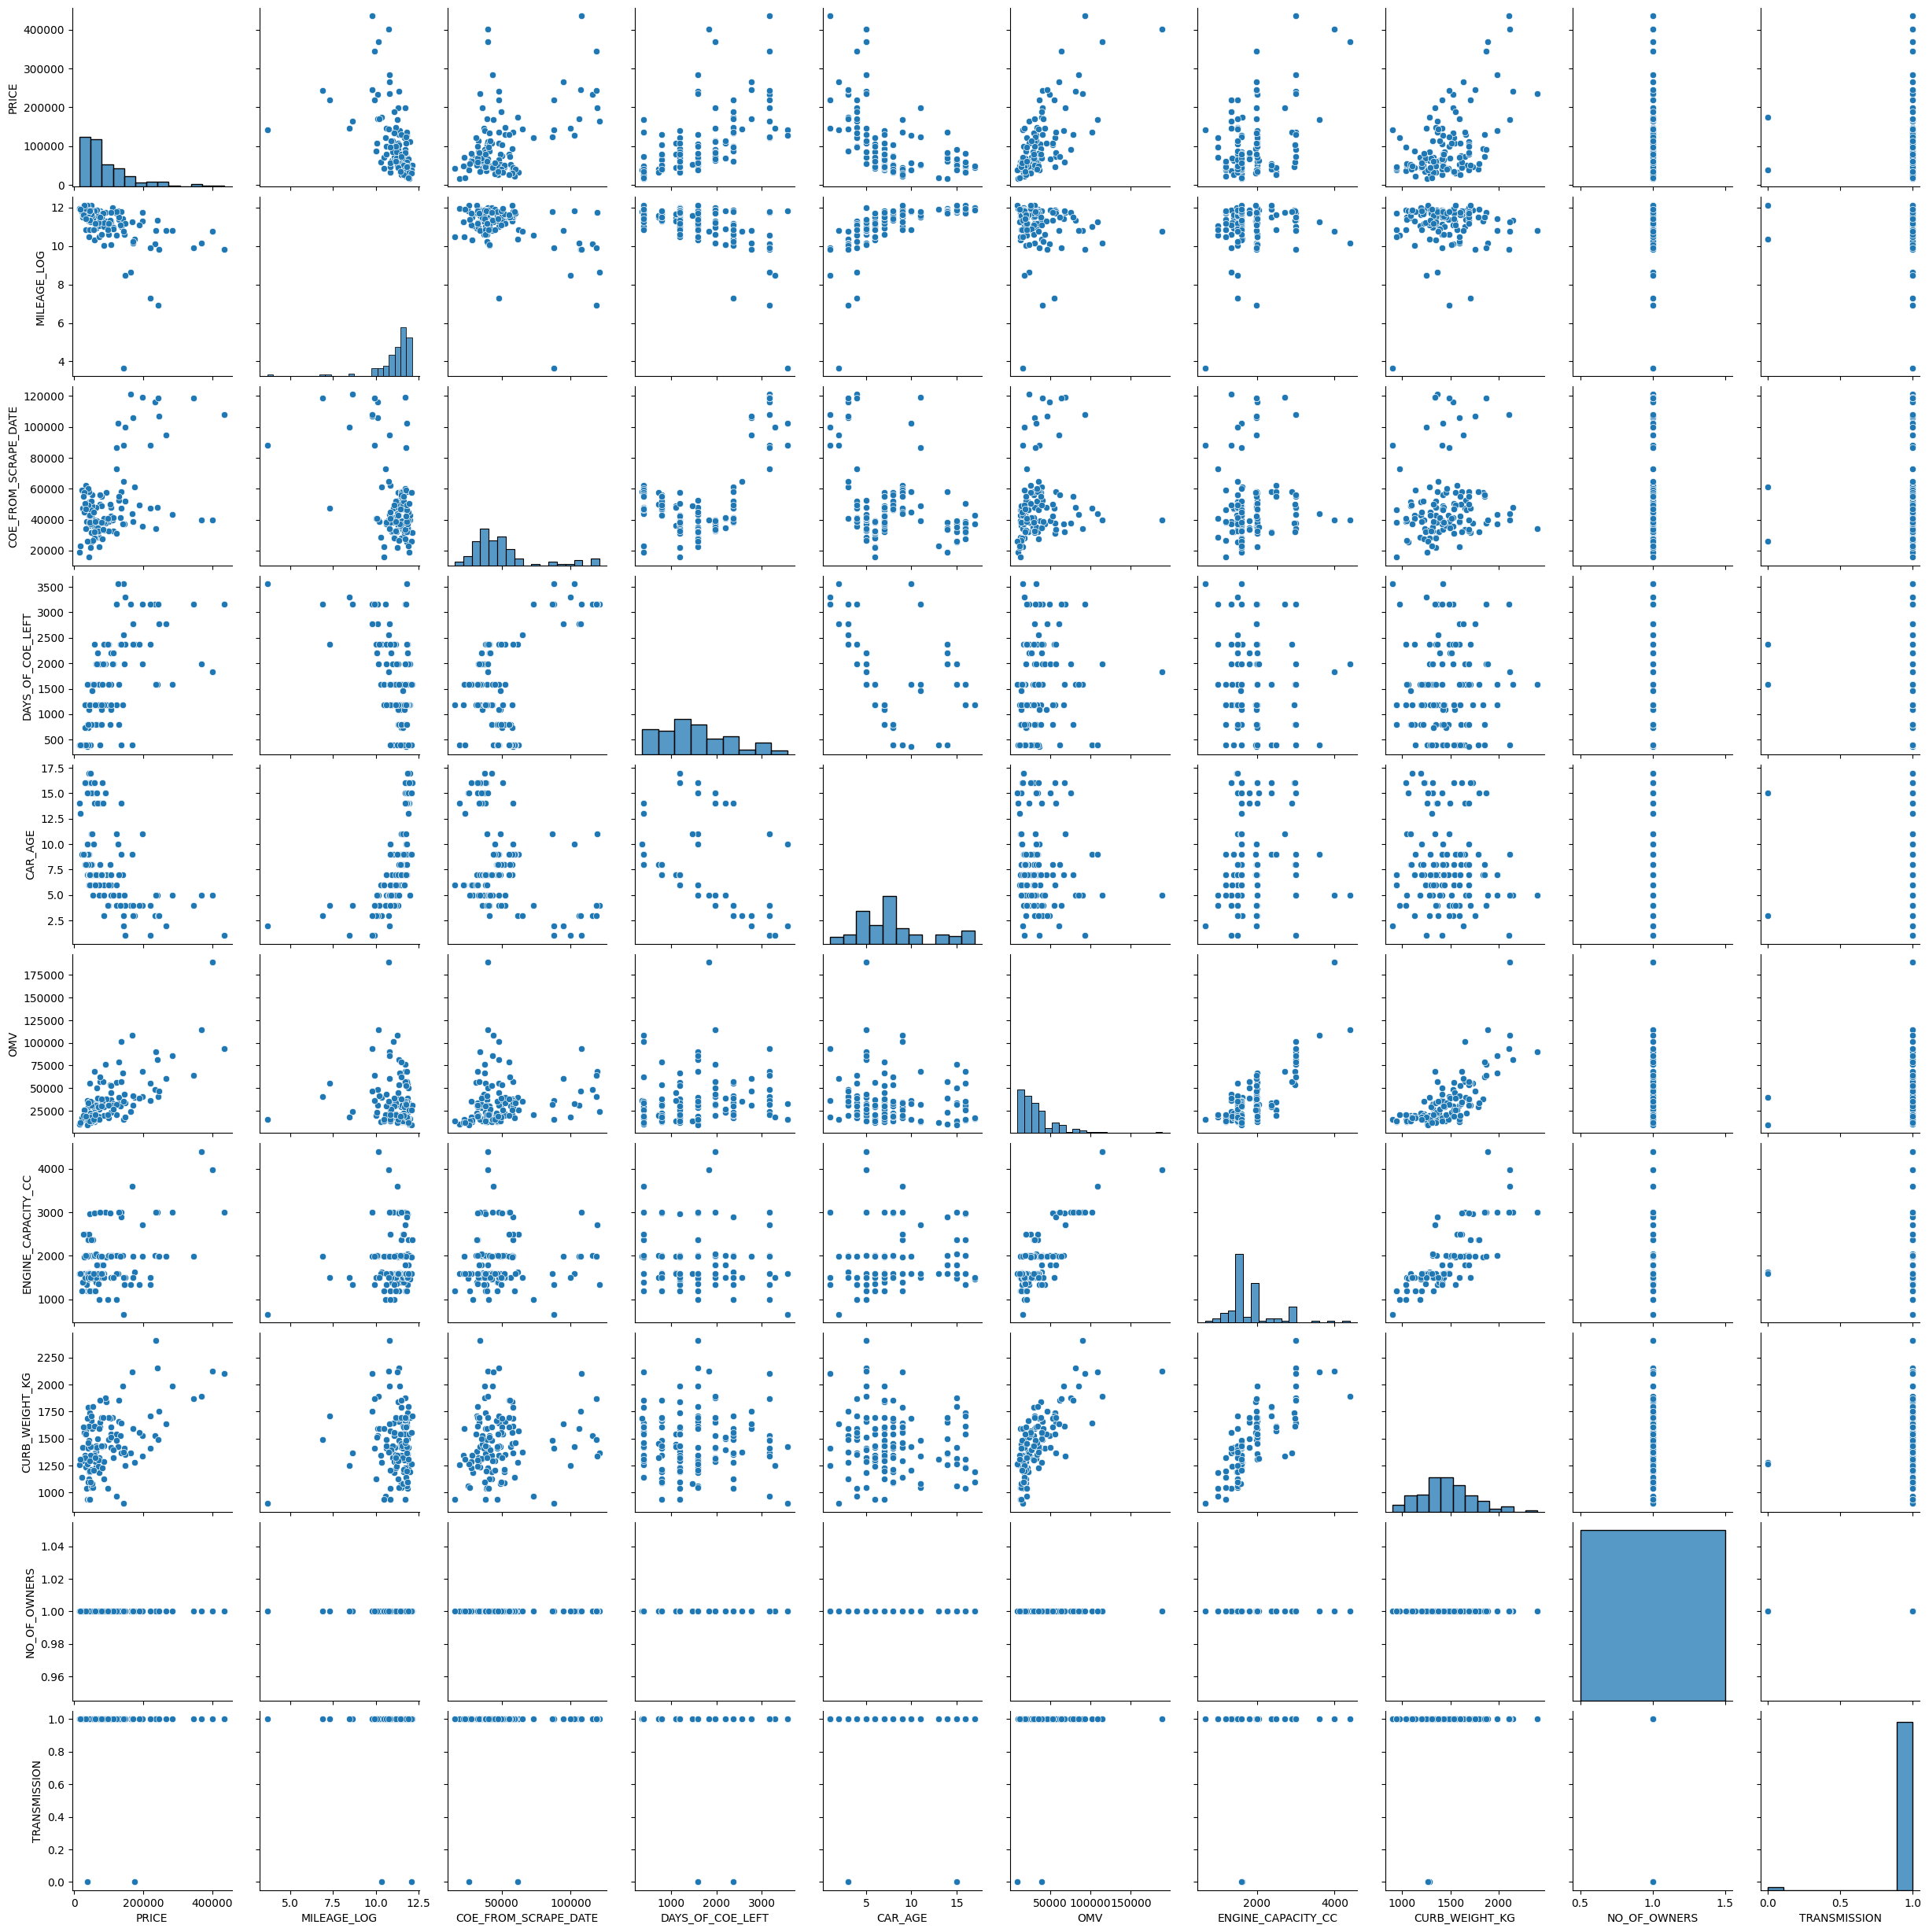

In [141]:
sns.pairplot(df_logged_price_no_brands_only_mileage_logged);
plt.savefig("log_price_and_mileage.png")

In [142]:
# Logging Price
df_logged_price_no_brands_only_mileage_logged['PRICE'] = df_logged_price_no_brands_only_mileage_logged['PRICE'].apply(np.log)

# Renaming column
df_logged_price_no_brands_only_mileage_logged.rename(columns={'PRICE':'PRICE_LOG'},inplace=True)

In [143]:
df_logged_price_no_brands_only_mileage_logged.columns

Index(['PRICE_LOG', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'],
      dtype='object')

In [144]:
df_logged_price_no_brands_only_mileage_logged.head()

,PRICE_LOG,MILEAGE_LOG,COE_FROM_SCRAPE_DATE,DAYS_OF_COE_LEFT,CAR_AGE,OMV,ENGINE_CAPACITY_CC,CURB_WEIGHT_KG,NO_OF_OWNERS,TRANSMISSION
0,12.006401,8.630522,121000.0,3168,4.0,24155.0,1332.0,1365.0,1,1
1,11.569306,11.134589,39401.0,1584,6.0,37248.0,1499.0,1415.0,1,1
3,12.071901,10.341742,61190.0,2376,3.0,39511.0,1618.0,1280.0,1,0
4,11.773750,11.360939,52502.0,1584,5.0,40167.0,1998.0,1660.0,1,1
6,10.858768,11.561716,56206.0,792,8.0,29860.0,1499.0,1425.0,1,1


In [145]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_logged_price_no_brands_only_mileage_logged[['MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'OMV', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'] ].astype(float)
Y = df_logged_price_no_brands_only_mileage_logged['PRICE_LOG'].astype(float)


# model / fit / summarize
print(linear_regression_analysis(X, Y))

                            OLS Regression Results                            
Dep. Variable:              PRICE_LOG   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     167.1
Date:                Mon, 09 Sep 2024   Prob (F-statistic):           2.74e-61
Time:                        21:42:21   Log-Likelihood:                 26.088
No. Observations:                 129   AIC:                            -34.18
Df Residuals:                     120   BIC:                            -8.438
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
MILEAGE_LOG              0.0103 

In [146]:
print(random_forest_analysis(X, Y))

{'RMSE': 0.07447137483526117, 'R^2': 0.9883068233274039}
